# **Analyzing the gradient leakage problem on a variety of vehicles**

In [1]:
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RESULTS_ROOT = "./04_distr_gradient_leakage/results/"

## **1. Statistical evaluation**

### 1.1 Averages

In [40]:
#reading the data:
vehicle_data = {}
for i in range(5):
    with open(RESULTS_ROOT+f"vehicle_results_{i}.json") as f:
        data = json.load(f)
        
    for veh in data:
        
        if veh.startswith("h"):
            veh_type = "household"
        elif veh.startswith("c"):
            veh_type = "commute"
        elif veh.startswith("r"):
            veh_type = "random"
            
        if i == 0:
            vehicle_data[veh] = {
                "position_rate": len(data[veh]["positions"]),
                "time_offset": data[veh]["time_offset"],
                "type": veh_type
            }
        else:
            vehicle_data[veh]["position_rate"] += len(data[veh]["positions"])
            vehicle_data[veh]["time_offset"] += np.abs(data[veh]["time_offset"])
            
gl_df = pd.DataFrame.from_dict(vehicle_data, orient="index")
gl_df["position_rate"] = gl_df["position_rate"]/5
gl_df["time_offset"] = gl_df["time_offset"]/5

In [41]:
gl_df

,position_rate,time_offset,type
h3076c1:0,9.2,2.6,household
h3220c1:0,9.0,0.0,household
carIn91:8,5.6,1.8,commute
randUni942:6,5.8,11.2,random
carIn636:5,6.4,0.2,commute
...,...,...,...
randUni504:6,4.8,6.8,random
carIn47:5,5.8,0.0,commute
randUni786:6,4.8,1.8,random
carIn494:6,6.2,5.8,commute


array([[<Axes: title={'center': 'position_rate'}>,
        <Axes: title={'center': 'time_offset'}>]], dtype=object)

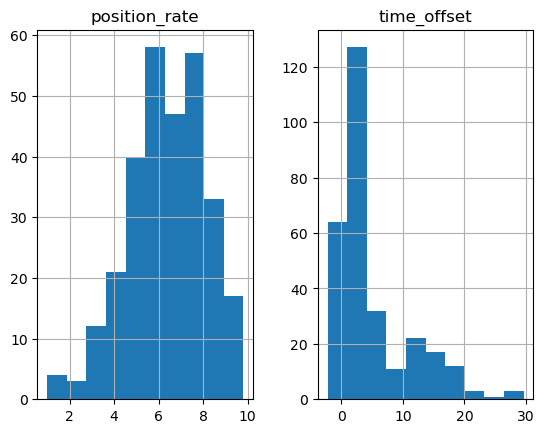

In [42]:
gl_df.hist()

In [43]:
gl_df.groupby("type").mean()

,position_rate,time_offset
type,,
commute,6.352795,1.857143
household,7.559091,4.359091
random,5.747126,11.358621


In [44]:
gl_df.groupby("type").std()

,position_rate,time_offset
type,,
commute,1.450606,1.636983
household,1.594514,5.905075
random,2.011932,6.546587


### 1.2 Extremal cases

In [7]:
gl_df["abs_time_offset"] = np.abs(gl_df["time_offset"])

In [8]:
gl_df[gl_df["position_rate"] == max(gl_df["position_rate"])]

,position_rate,time_offset,type,abs_time_offset
h3296c1:0,9.8,1.8,household,1.8


In [9]:
gl_df[gl_df["position_rate"] == min(gl_df["position_rate"])]

,position_rate,time_offset,type,abs_time_offset
randUni401:7,1.0,18.6,random,18.6
randUni492:4,1.0,5.6,random,5.6


In [10]:
gl_df[gl_df["abs_time_offset"] == max(gl_df["abs_time_offset"])]

,position_rate,time_offset,type,abs_time_offset
randUni215:8,2.4,29.6,random,29.6


In [11]:
gl_df[gl_df["abs_time_offset"] == min(gl_df["abs_time_offset"])]

,position_rate,time_offset,type,abs_time_offset
h3220c1:0,9.0,0.0,household,0.0
carIn355:7,6.0,0.0,commute,0.0
carIn512:6,7.6,0.0,commute,0.0
carIn428:6,5.6,0.0,commute,0.0
carIn865:8,7.2,0.0,commute,0.0
carIn371:7,5.2,0.0,commute,0.0
carIn764:7,5.4,0.0,commute,0.0
h2543c1:0,6.4,0.0,household,0.0
carIn834:6,7.2,0.0,commute,0.0
carIn436:7,5.0,0.0,commute,0.0


### 1.3 Distributions by vehicle type

Text(0, 0.5, 'matched parkings')

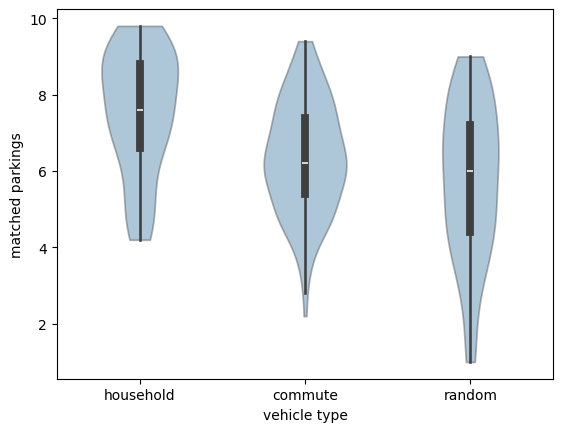

In [12]:
sns.violinplot(data = gl_df, x = "type", y = "position_rate",
               cut = 0, #fixing to the data's scale
               width=0.5, alpha=0.4)
plt.xlabel("vehicle type")
plt.ylabel("matched parkings")
#plt.title("Success rate distribution of matched parking lots\nby vehicle type category")

Text(0, 0.5, 'abs. time offset [15 min]')

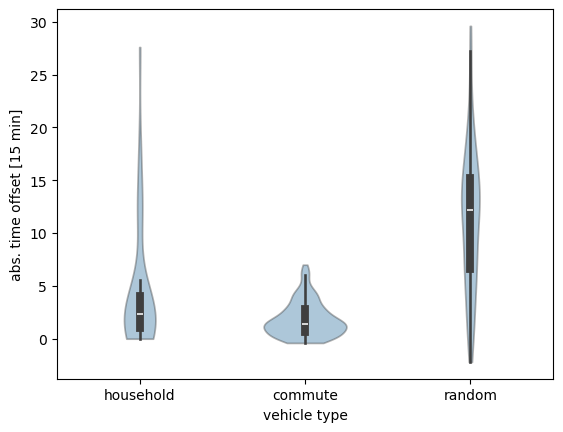

In [14]:
sns.violinplot(data = gl_df, x = "type", y = "time_offset",
               cut = 0, #fixing to the data's scale
               width=0.5, alpha=0.4)
plt.xlabel("vehicle type")
plt.ylabel("abs. time offset [15 min]")
#plt.title("Success rate distribution of identified moving time\nby vehicle type category")

## **2. Checking the Household traffic**

### 2.1 Clustering

The `household` vehicle type seems to produce a Gaussian mixture distribution (with means around 0, and 15) in terms of time offset. To check this out, we try to create 2 clusters, corresponding to these Gaussian distributions. Later on, we will compare this two clusters.

In [15]:
import copy
from sklearn.cluster import KMeans

household_gl_df = copy.deepcopy(gl_df[gl_df["type"] == "household"])
X = np.array(household_gl_df["time_offset"]).reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42).fit(X) #fix seed to always have the same clusters
household_gl_df["cluster"] = kmeans.predict(X)

In [16]:
household_gl_df

,position_rate,time_offset,type,abs_time_offset,cluster
h3076c1:0,9.2,2.6,household,2.6,0
h3220c1:0,9.0,0.0,household,0.0,0
h3028c1:0,9.2,5.6,household,5.6,0
h3170c1:0,7.6,3.2,household,3.2,0
h3120c1:0,9.6,1.4,household,1.4,0
h707c1:0,6.6,2.6,household,2.6,0
h2335c1:0,8.2,18.2,household,18.2,1
h2557c2:0,4.8,0.4,household,0.4,0
h2483c1:0,6.2,1.4,household,1.4,0
h310c1:0,7.4,3.4,household,3.4,0


Text(0, 0.5, 'matched parkings')

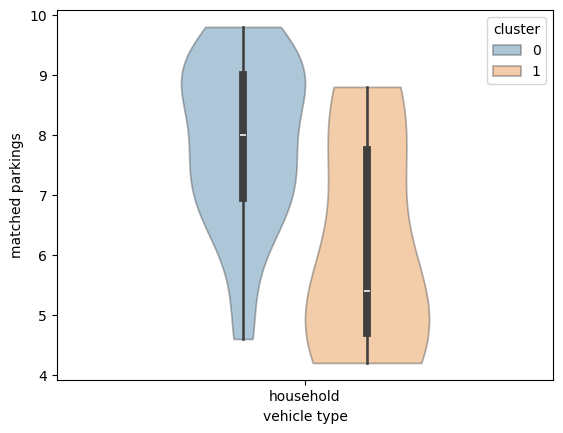

In [17]:
sns.violinplot(data = household_gl_df, x = "type", y = "position_rate", hue = "cluster",
               cut = 0, #fixing to the data's scale
               width=0.5, alpha=0.4)
plt.xlabel("vehicle type")
plt.ylabel("matched parkings")
#plt.title("Success rate distribution of matched parking lots\nin household category")

Text(0, 0.5, 'abs. time offset [15 min]')

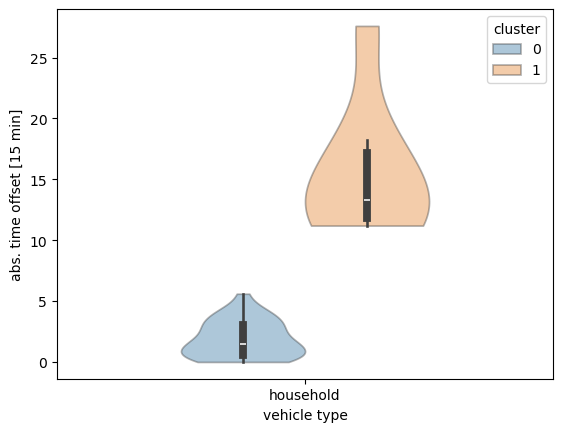

In [19]:
sns.violinplot(data = household_gl_df, x = "type", y = "time_offset", hue = "cluster",
               cut = 0,
               width=0.5, alpha=0.4)
plt.xlabel("vehicle type")
plt.ylabel("abs. time offset [15 min]")
#plt.title("Success rate distribution of identified moving time\nin household category")

### 2.2 Visualizing movings

In [24]:
SIM_RESULTS_ROOT = "../01_simulation/04_results/"
SEEDS = ['42', '1234', '1867', '613', '1001']
PARKING_DEFINITION_FILE = "../01_simulation/02_scenario/parking_areas.add.xml"
NET_FILE = "../01_simulation/02_scenario/rand_grid.net.xml"

In [25]:
p_data = pd.DataFrame()
#READING DATA:
for s in SEEDS:
    filename = SIM_RESULTS_ROOT+f'poccup_by_vehs_{s}.csv'
    pf = pd.read_csv(filename)
    pf["seed"] = [s]*len(pf)
    p_data = pd.concat([p_data, pf])
    
p_data["time"] = p_data["time"] - 4*24*60*60
p_data["time"] = p_data["time"].astype(int)
p_data["time_of_day"] = (p_data["time"] - (p_data["time"] // (24*60*60))*24*60*60) / (24*60*60) #converting to 0.0-1.0 and removing periodicity

In [26]:
parking_df = pd.read_xml(PARKING_DEFINITION_FILE)

In [27]:
edges = []
for i,r in parking_df.iterrows():
    edges.append(r.lane.split("_")[0])
parking_df["edge"] = edges

parking_positions = {}
for i,r in parking_df.iterrows():
    parking_positions[r.id] = r.edge

In [28]:
from importlib import reload
import visualization

reload(visualization);

#### Cluster1

9025 / 30
4058 / 21
3653 / 20
9010 / 37
7487 / 28
9567 / 30
6327 / 21
6106 / 21


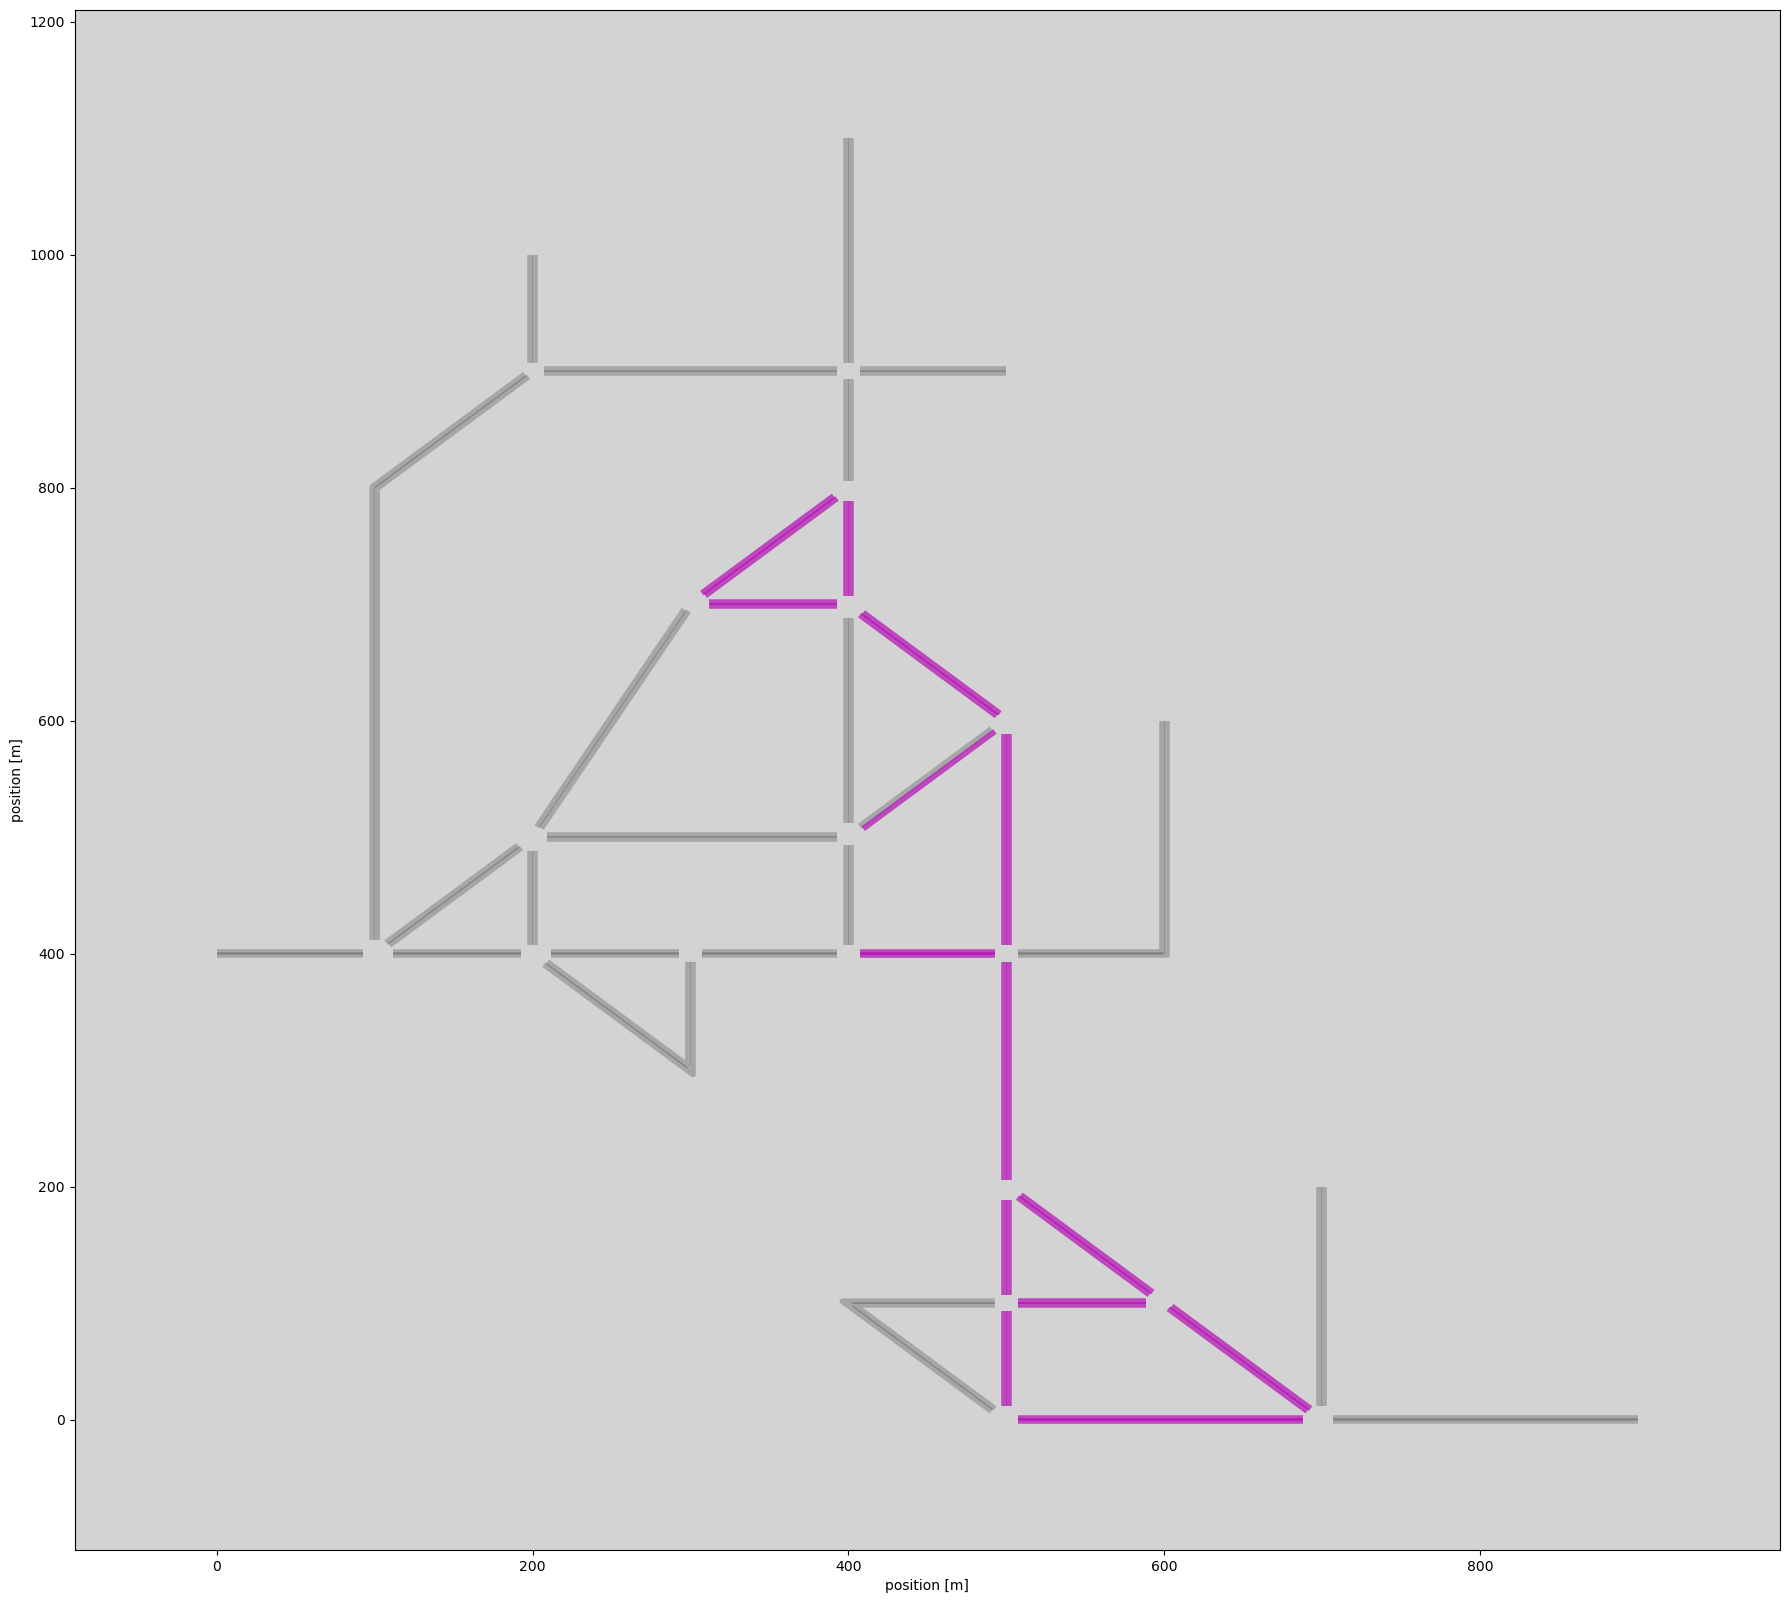

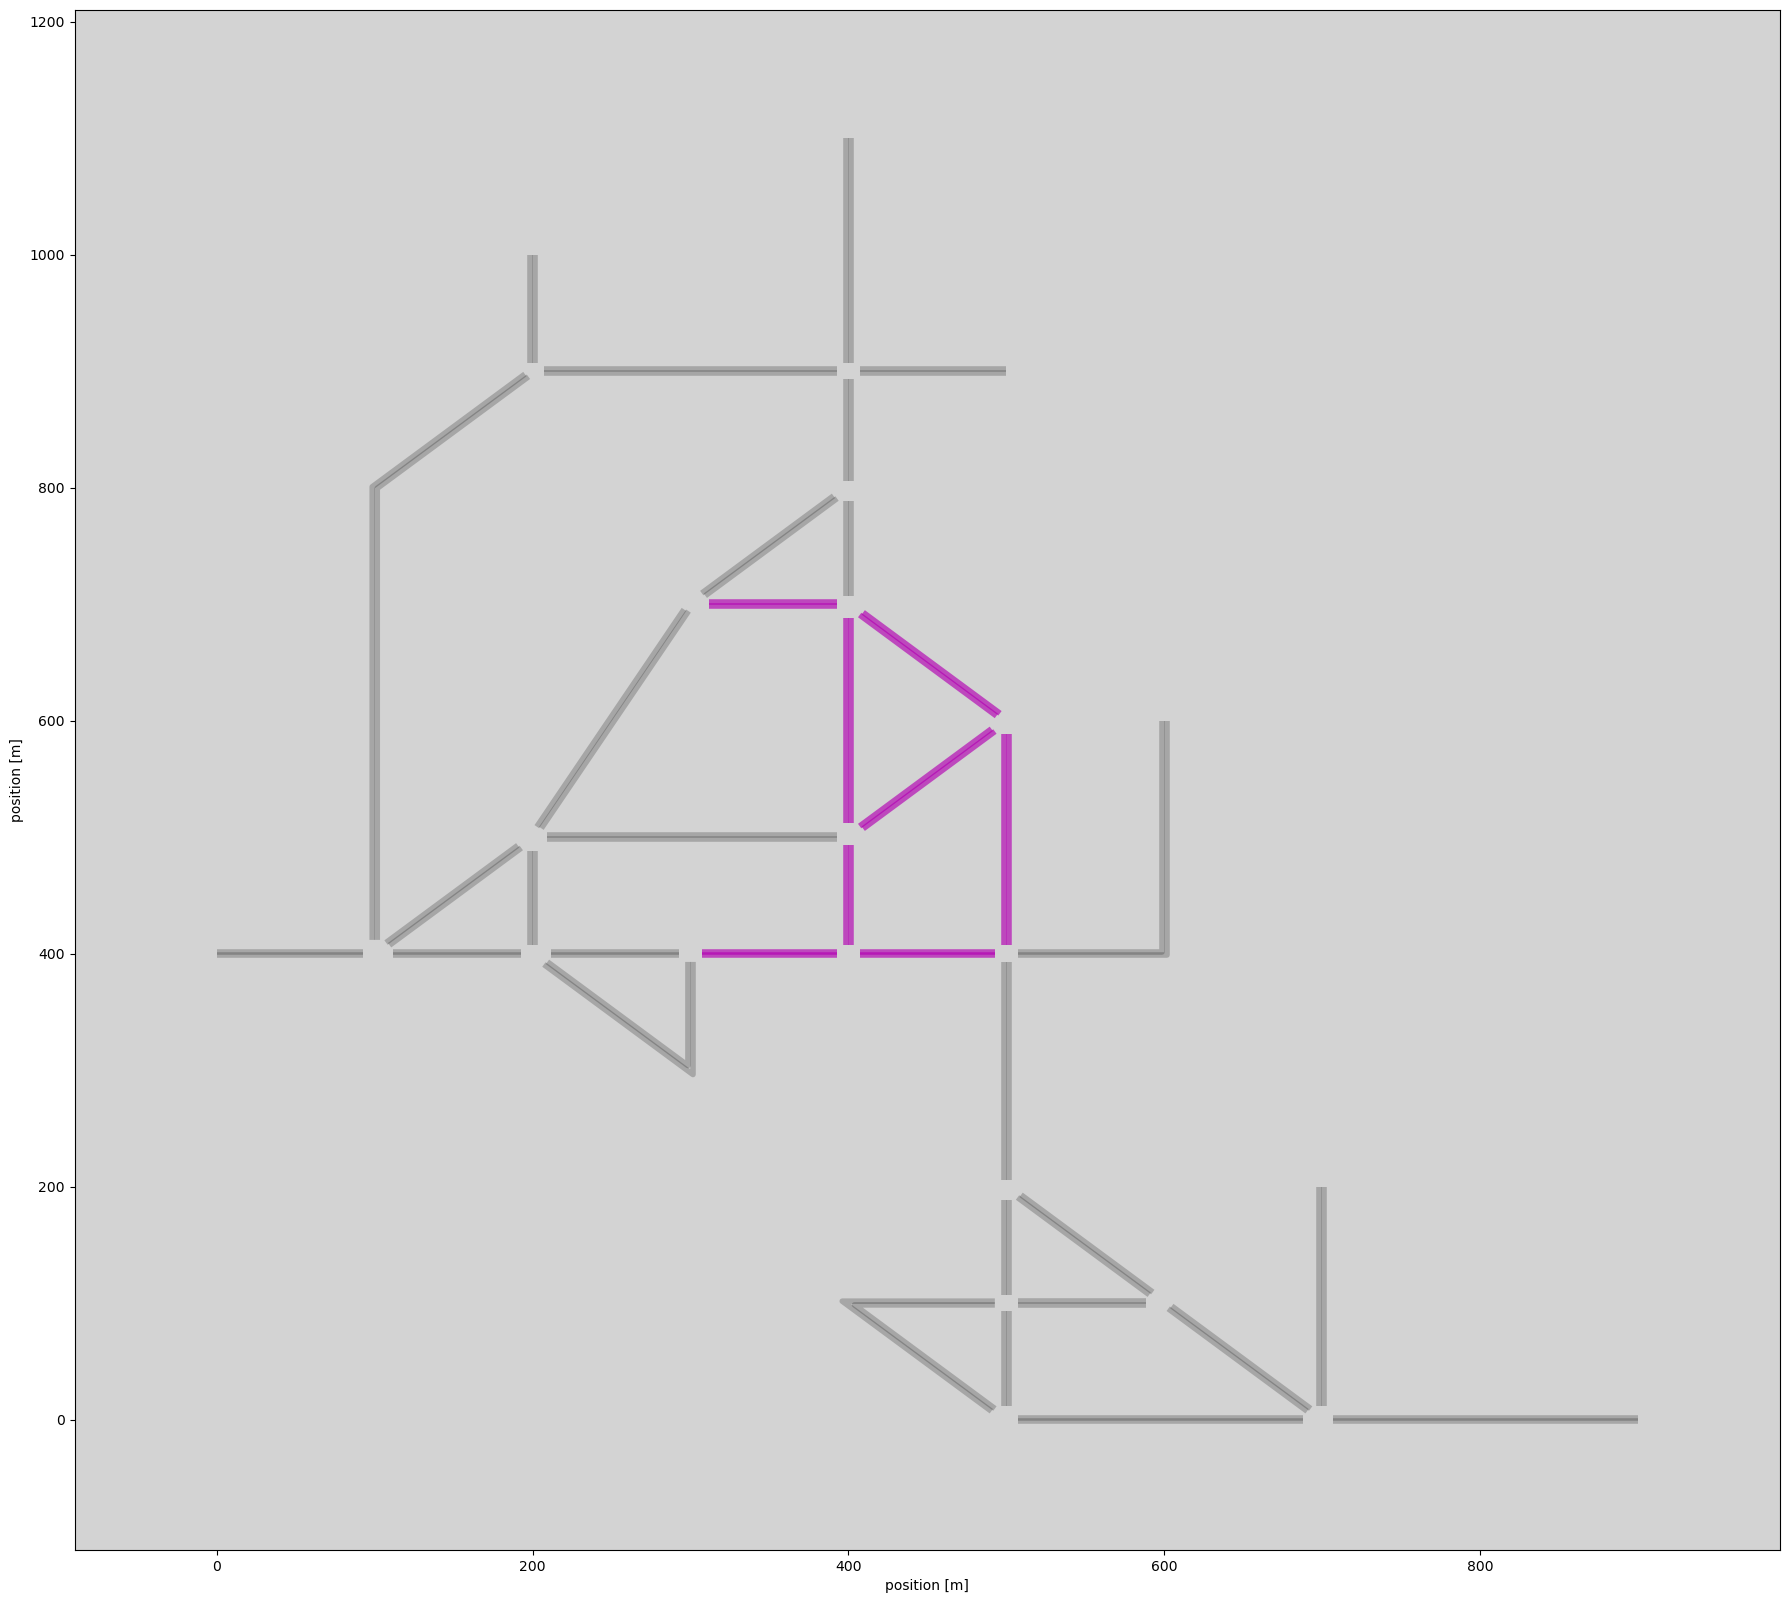

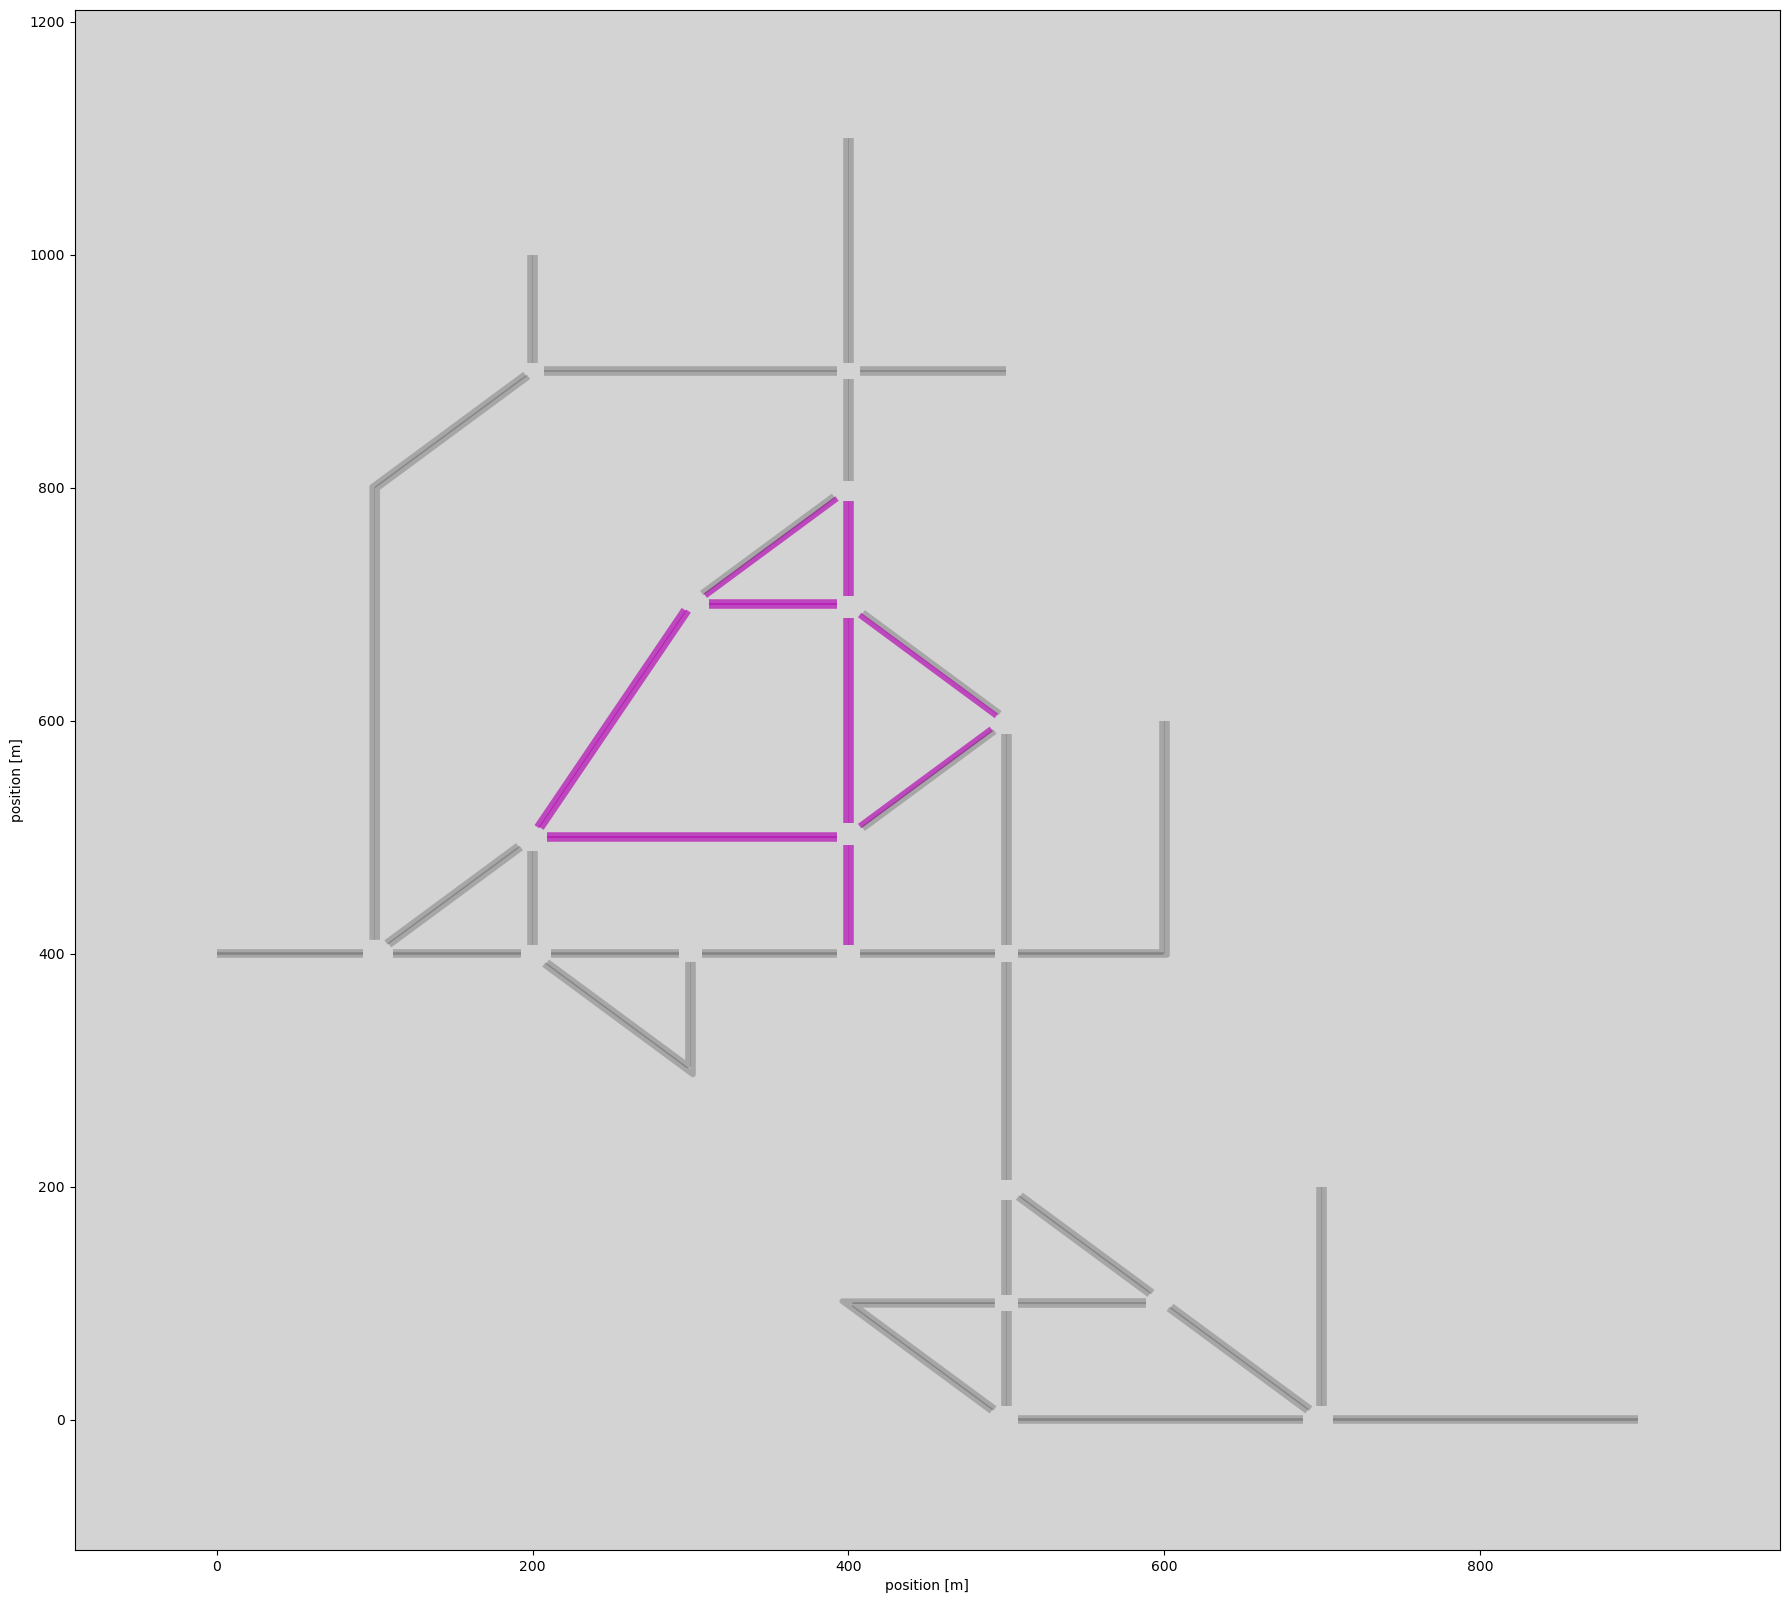

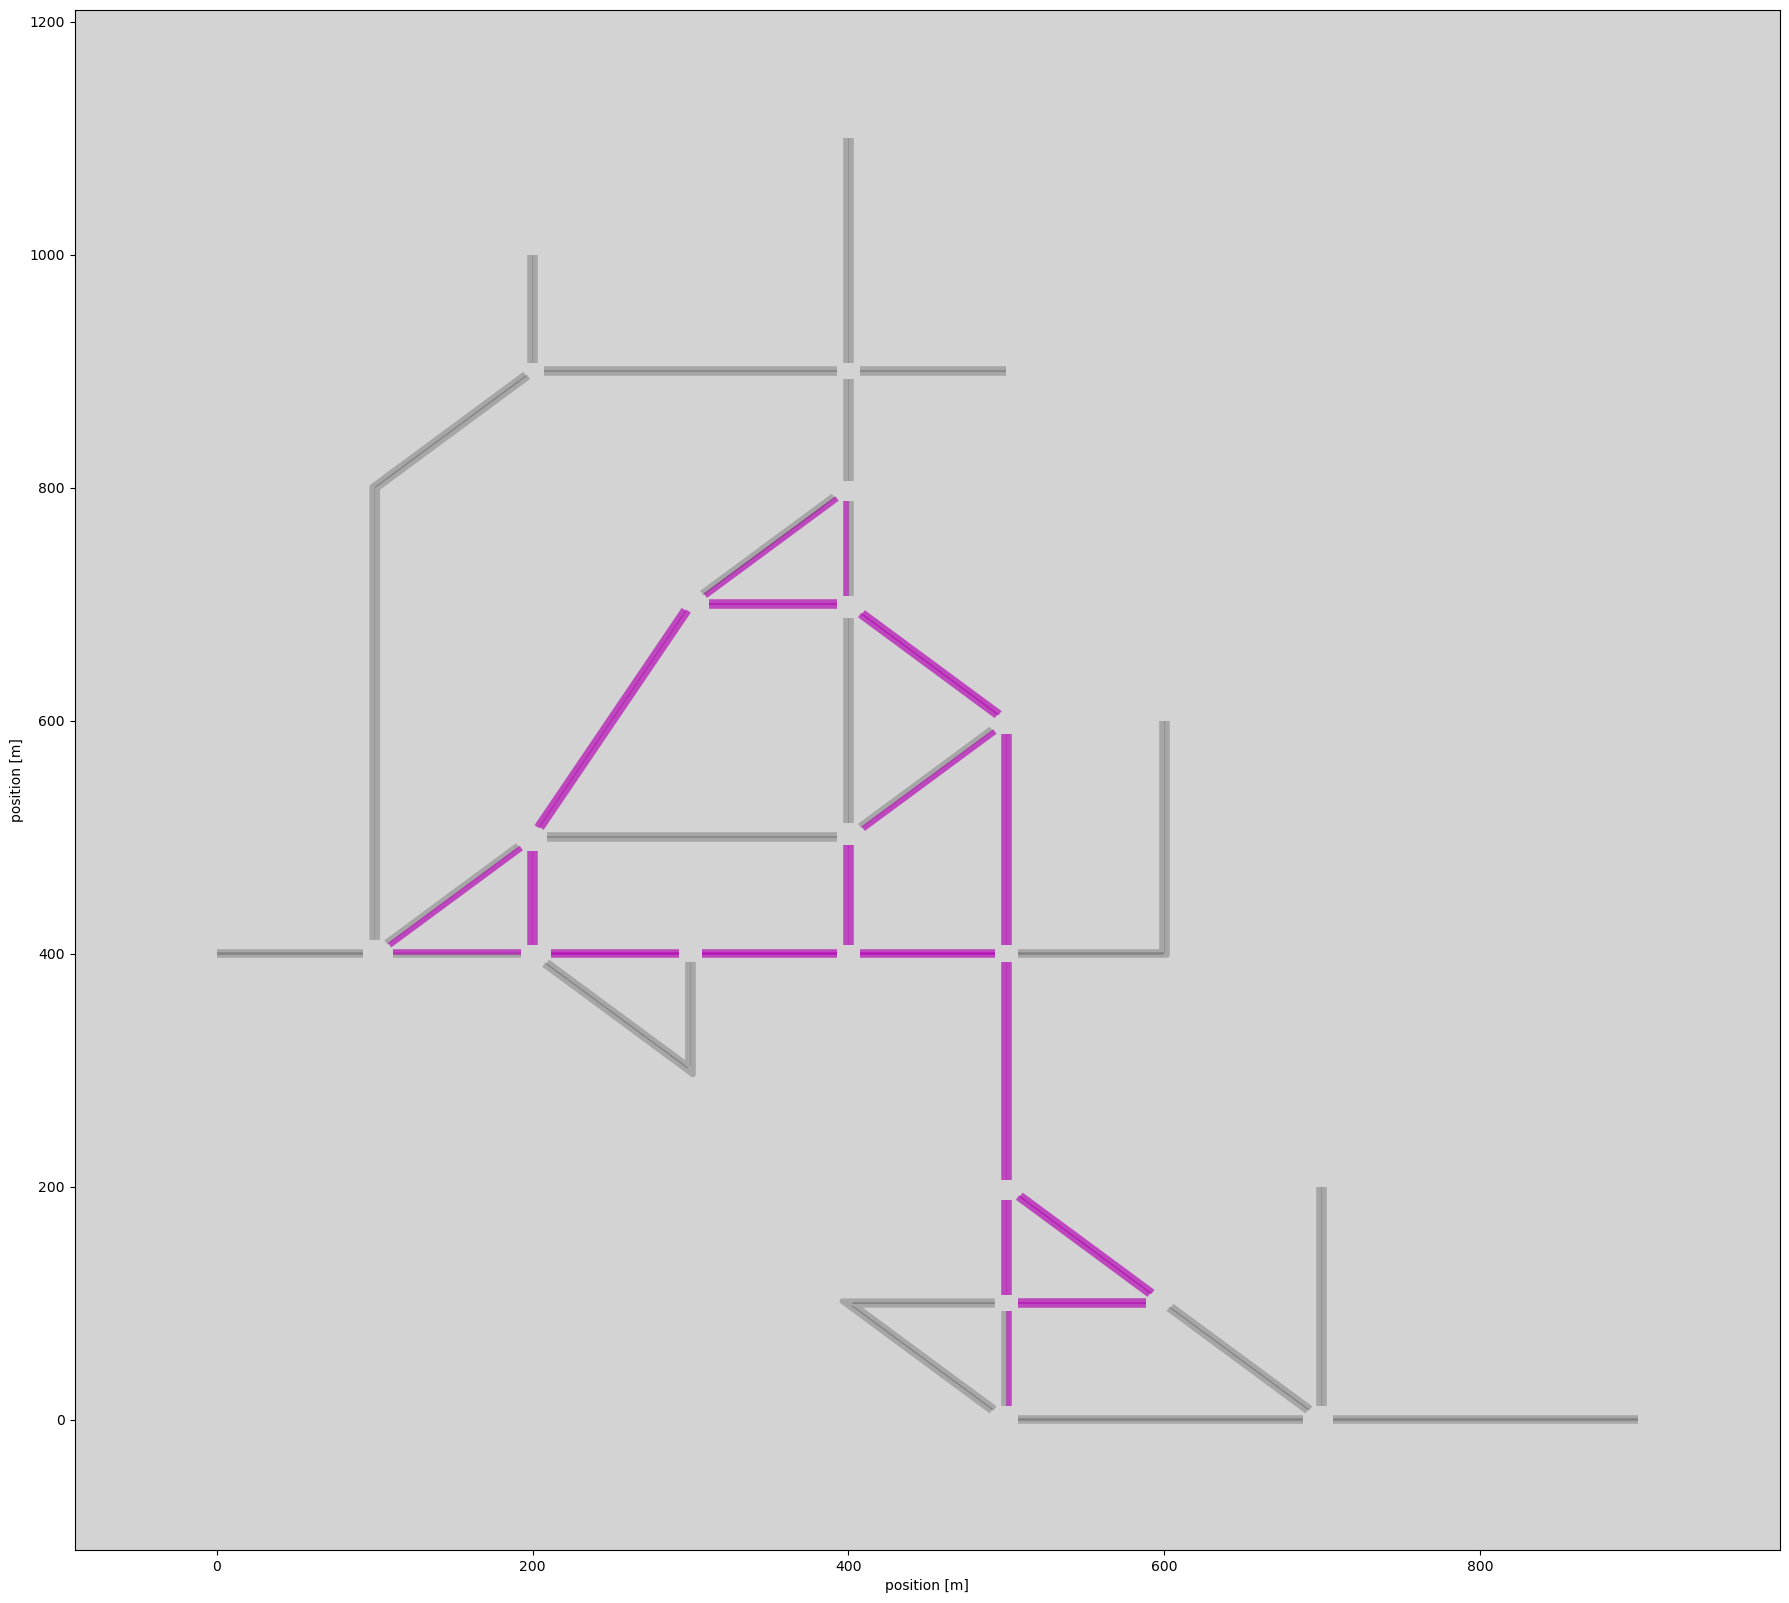

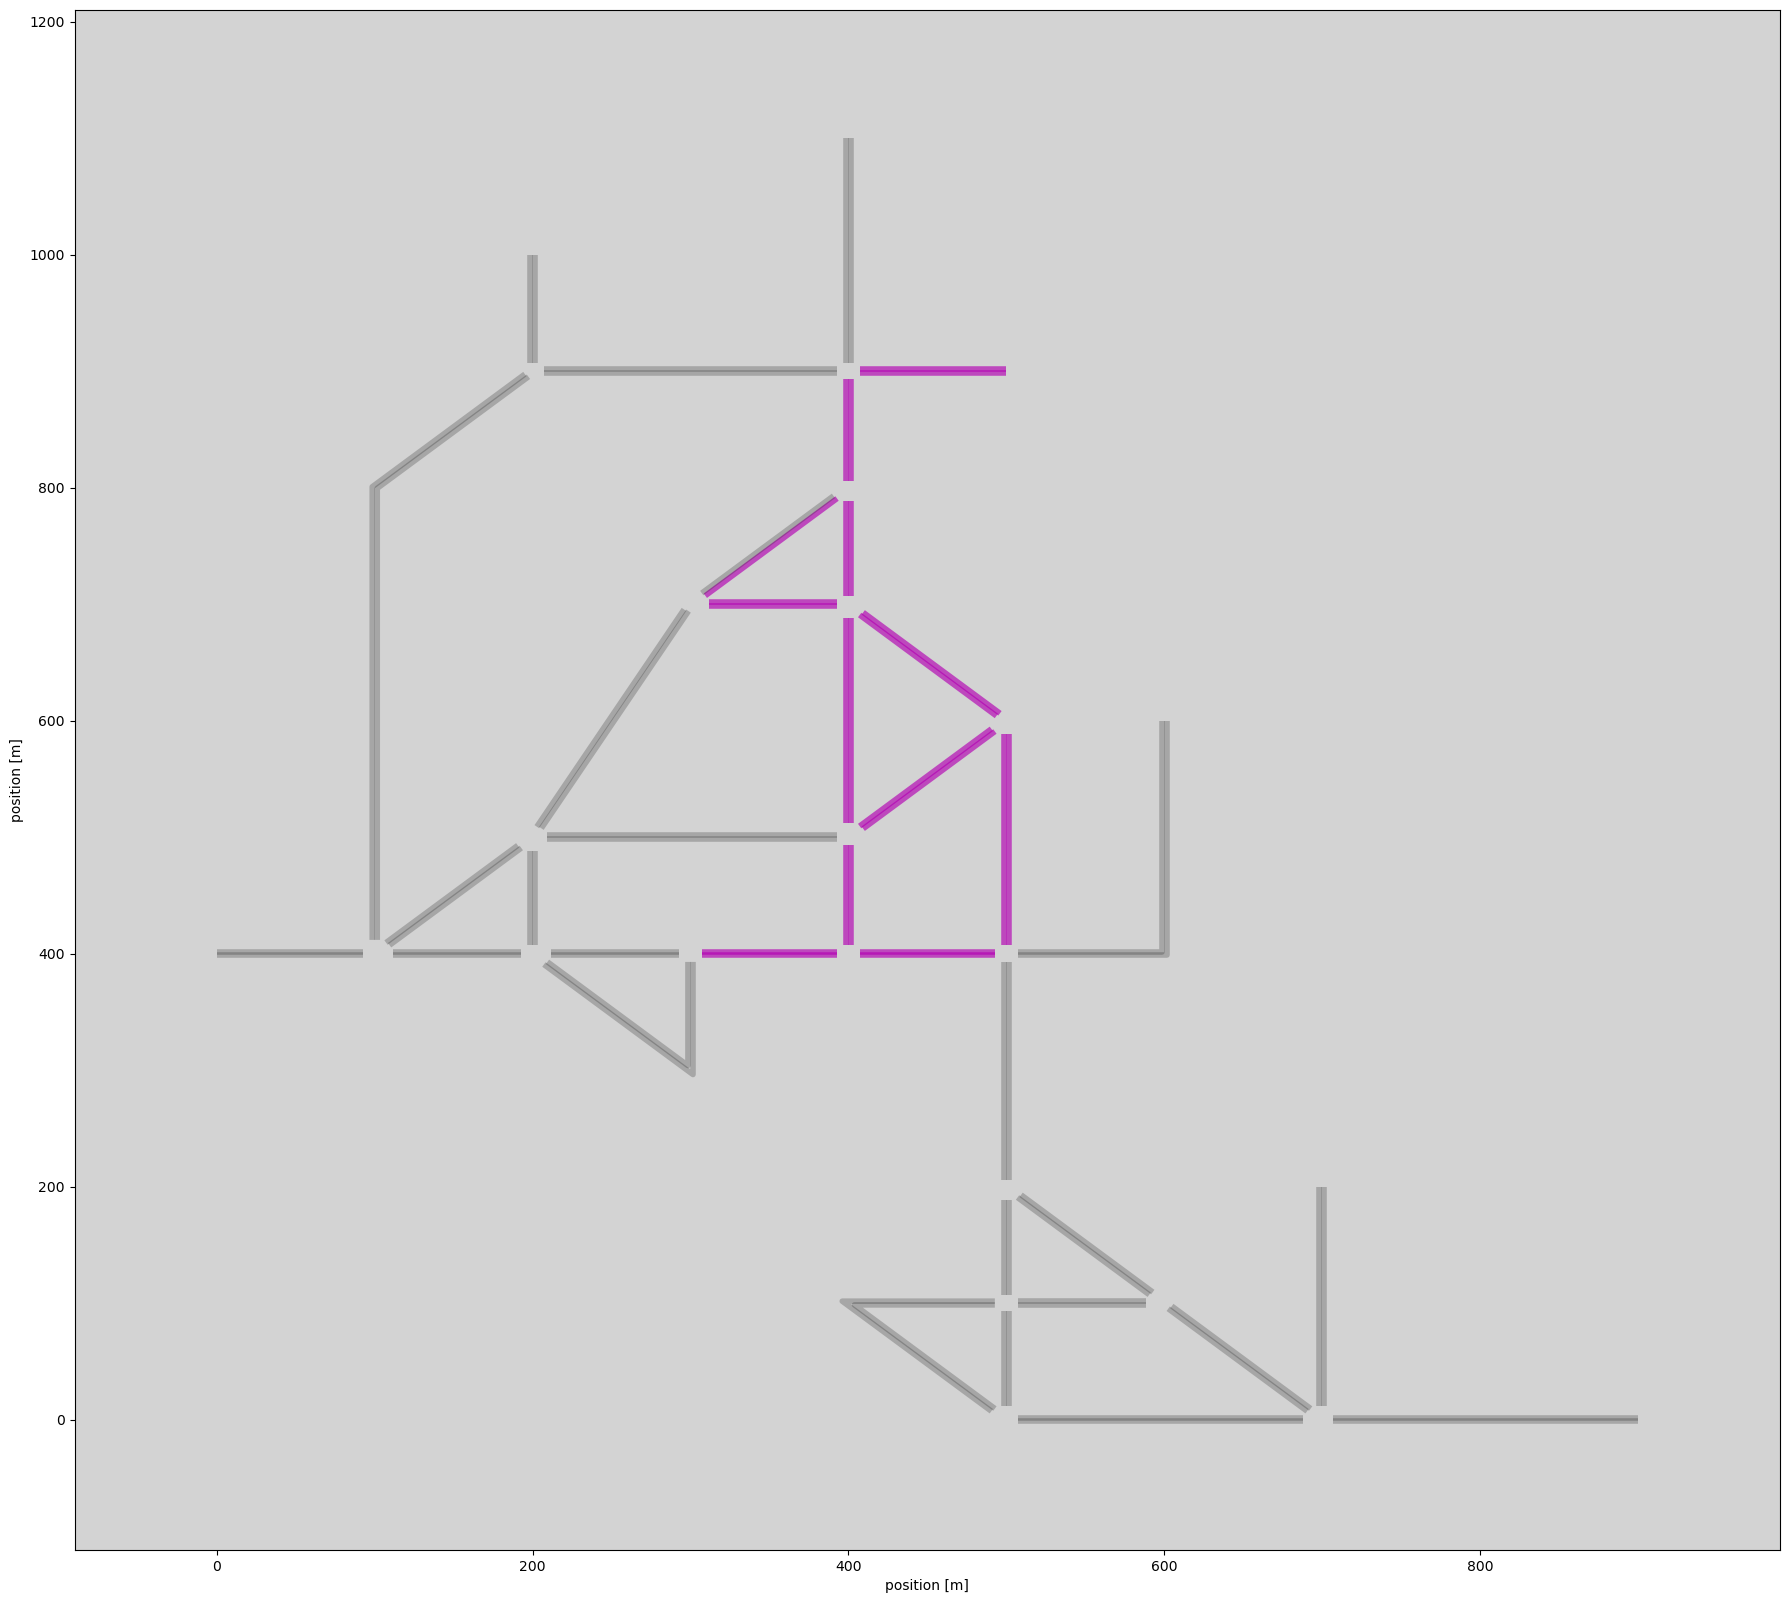

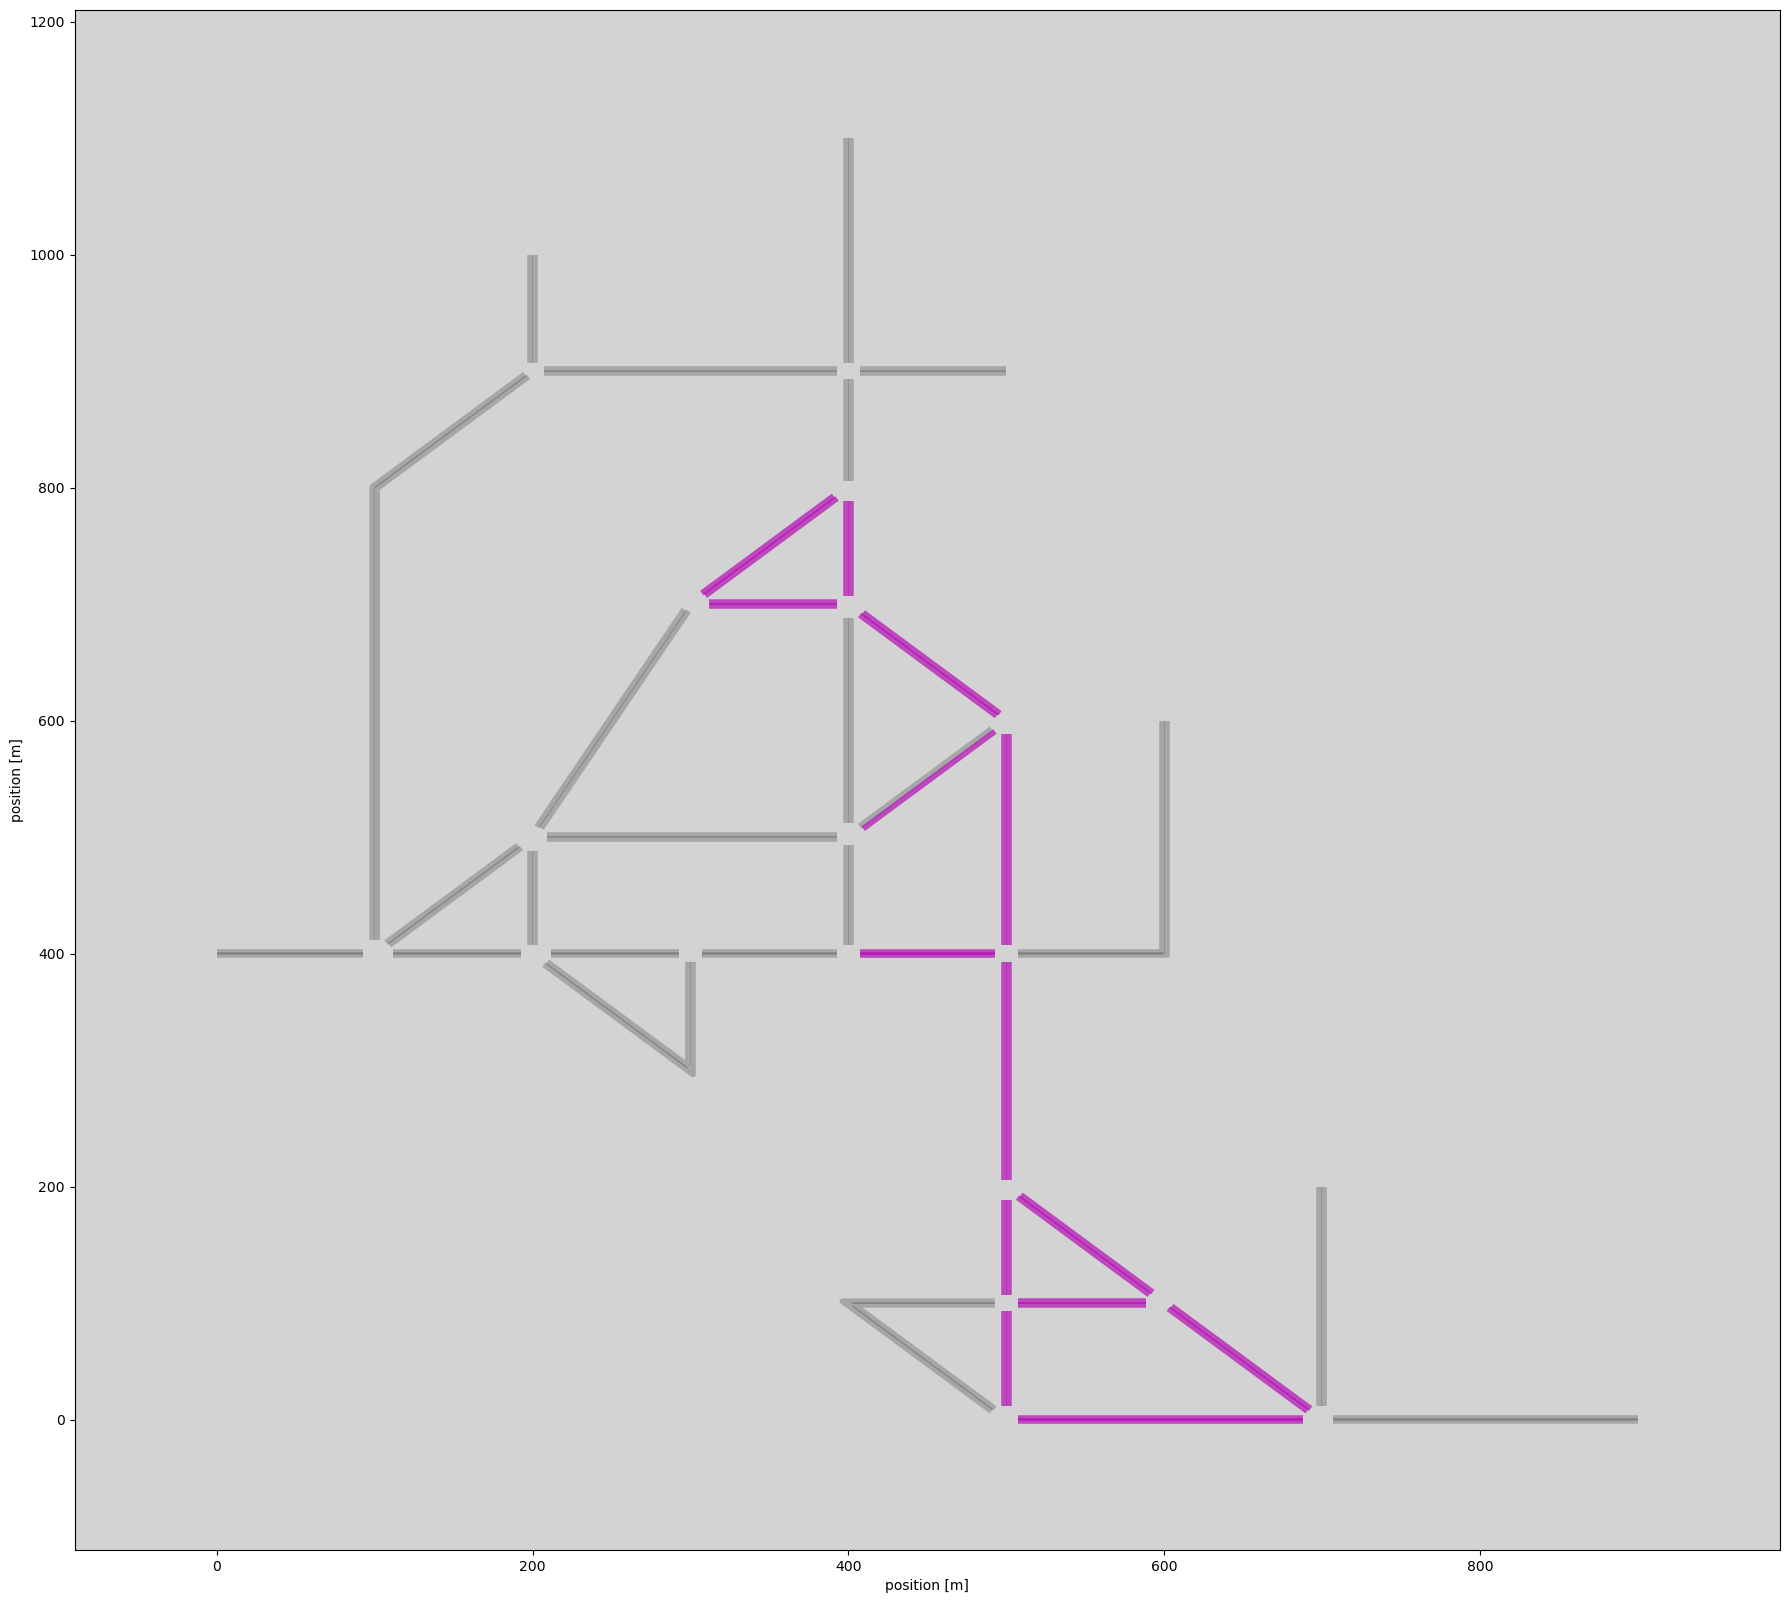

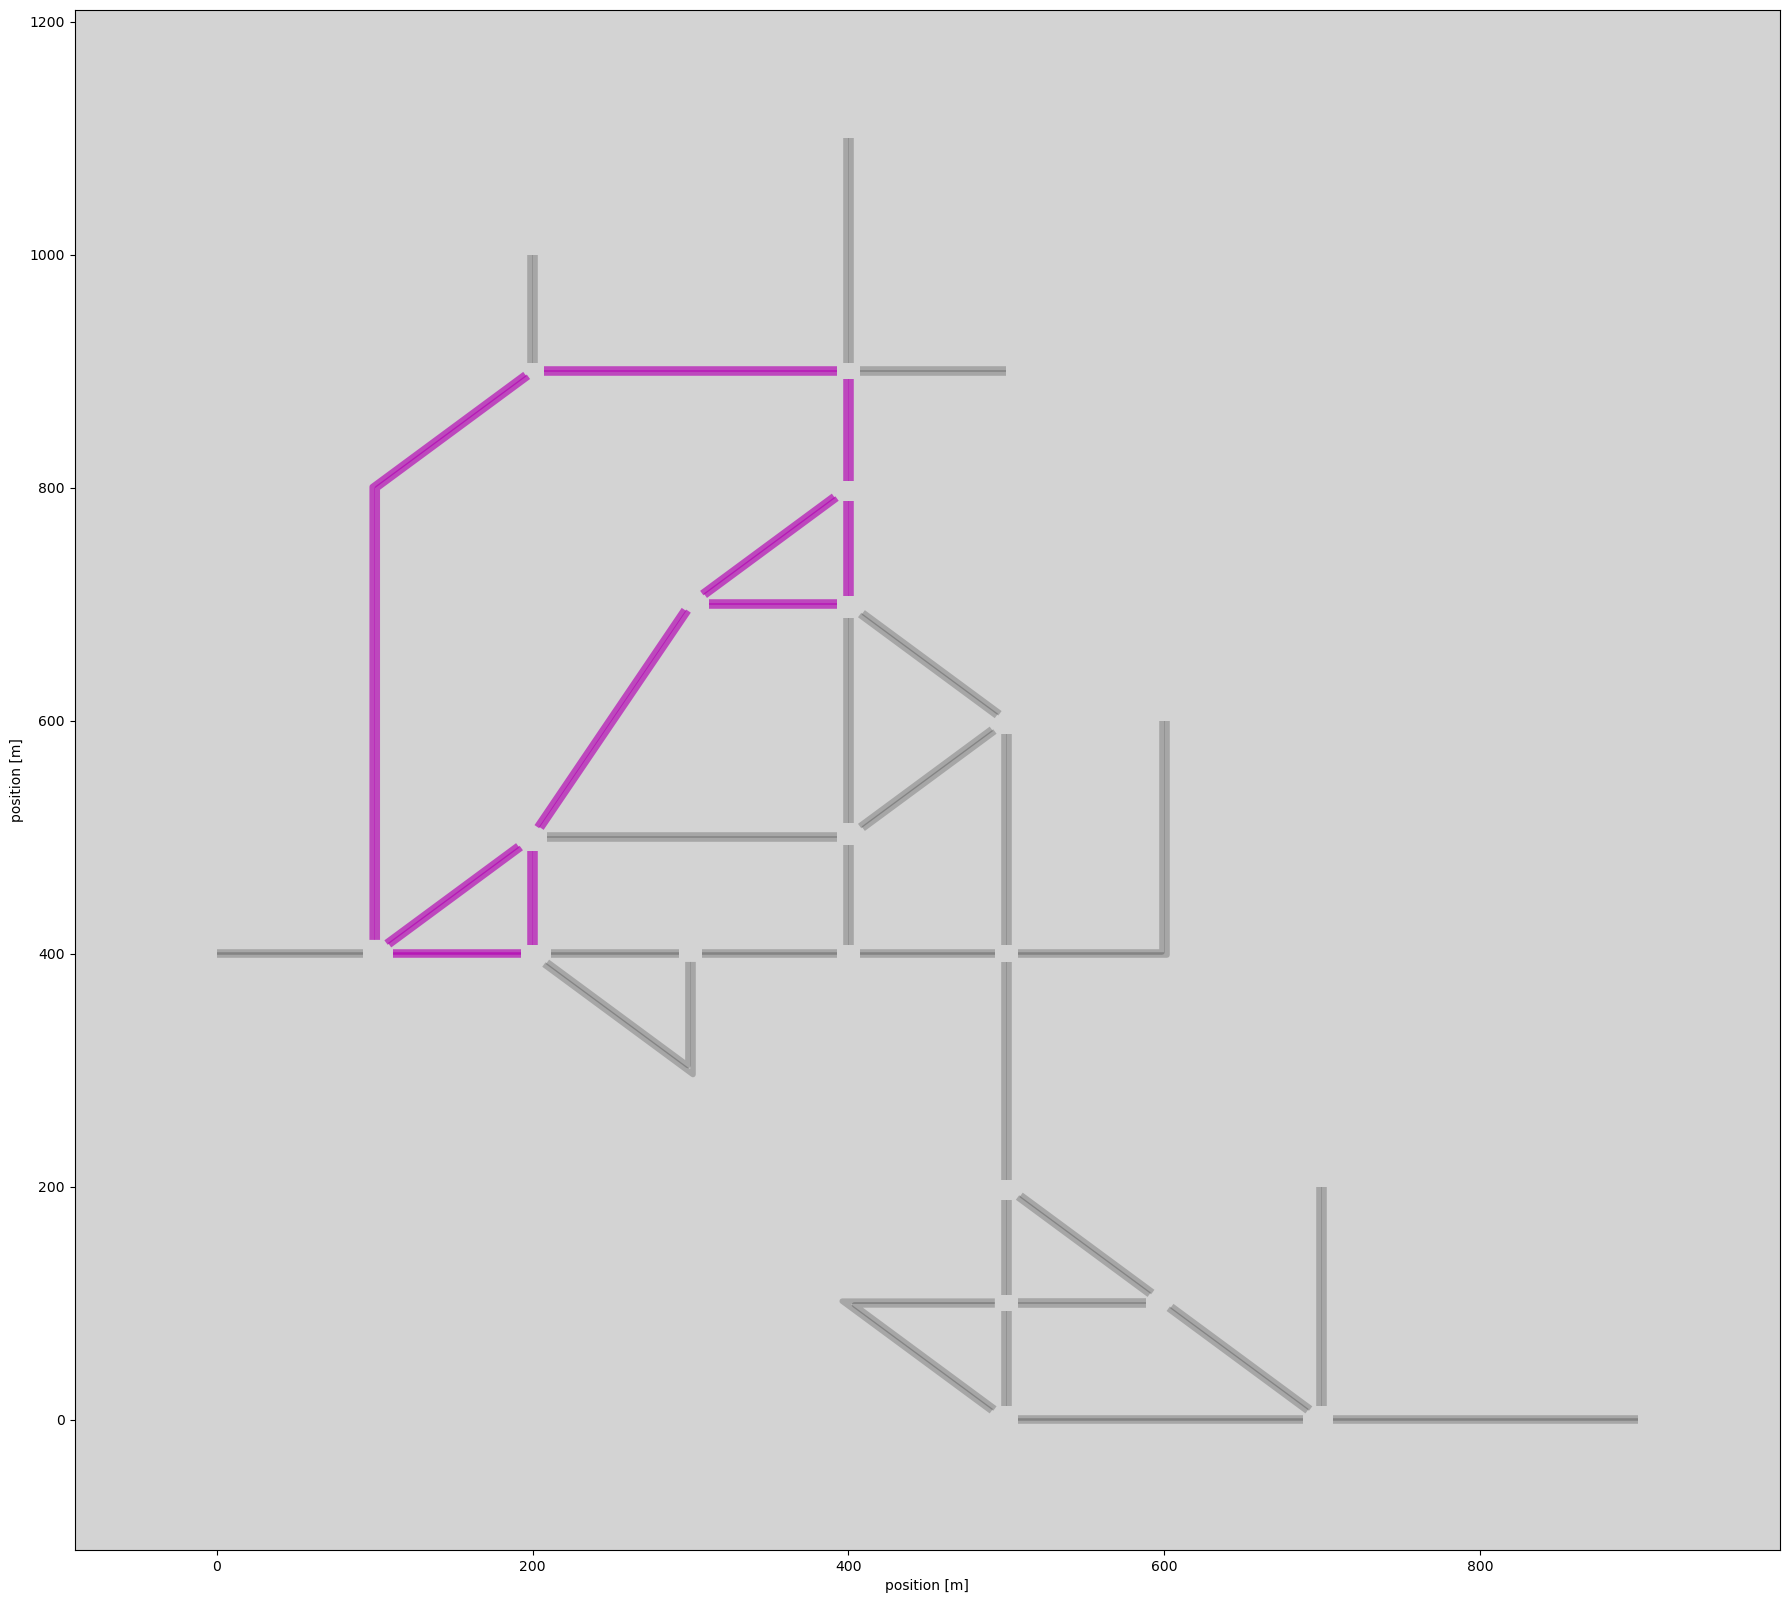

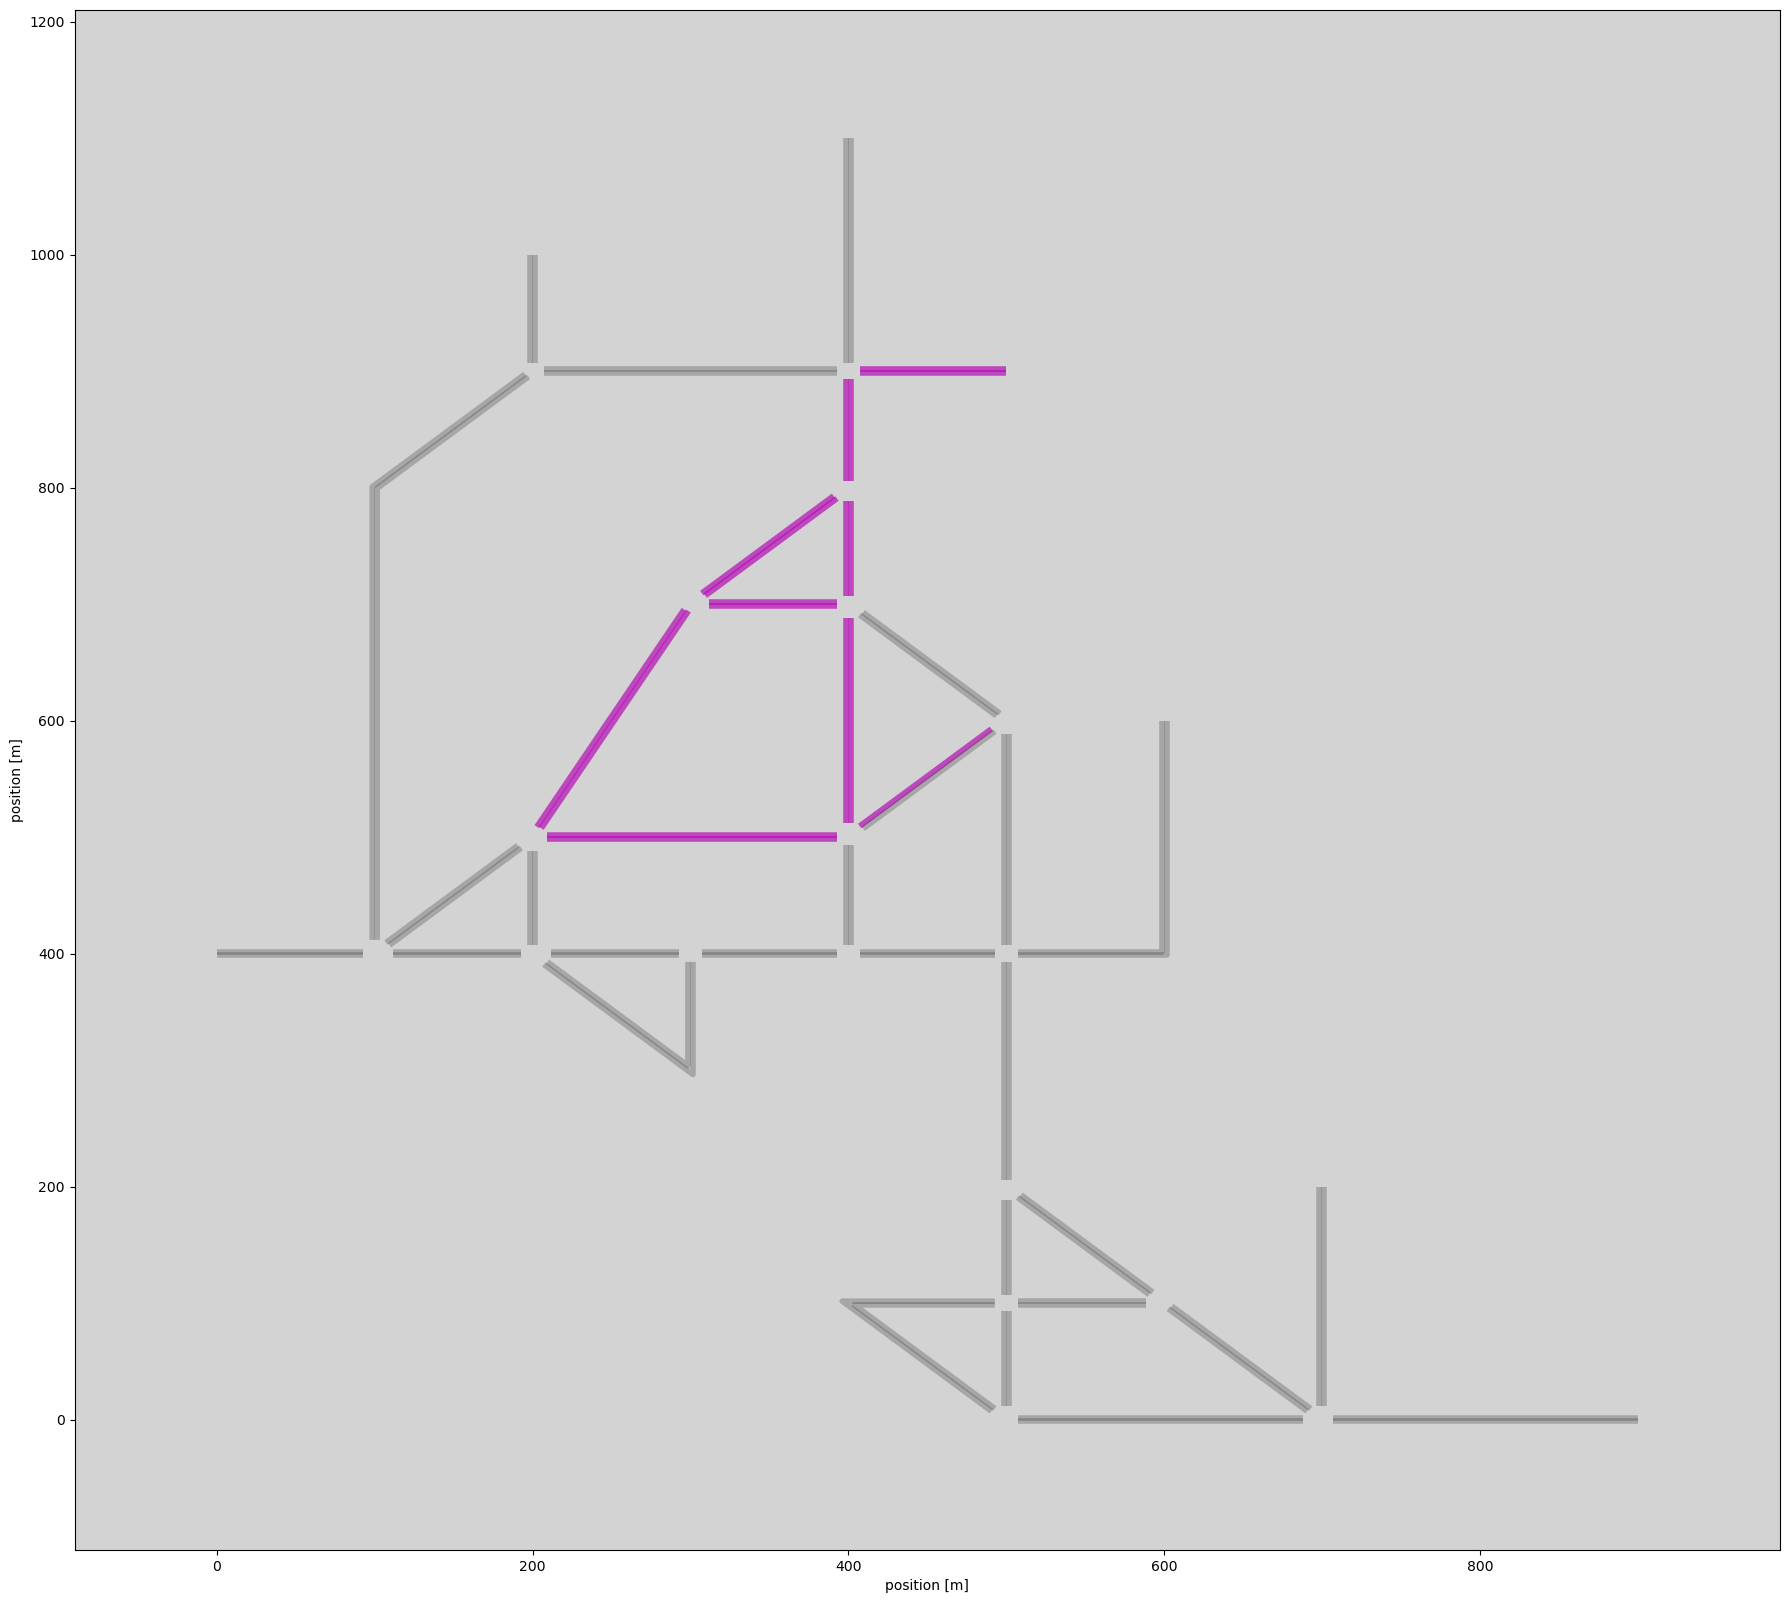

In [29]:
cluster1 = household_gl_df[household_gl_df["cluster"] == 1].index
for veh in cluster1:
    p_veh_data = p_data[p_data["veh_id"] == veh]
    print(len(p_veh_data), "/", len(p_veh_data["parking_id"].unique()))
    veh_lots = p_veh_data["parking_id"]
    visualization.plot_dataset(NET_FILE, veh_lots, parking_positions)

#### Cluster0

7387 / 31
9339 / 37
8637 / 40
5820 / 21
16519 / 42
5382 / 34
6858 / 27
6701 / 34
5553 / 36
18422 / 49


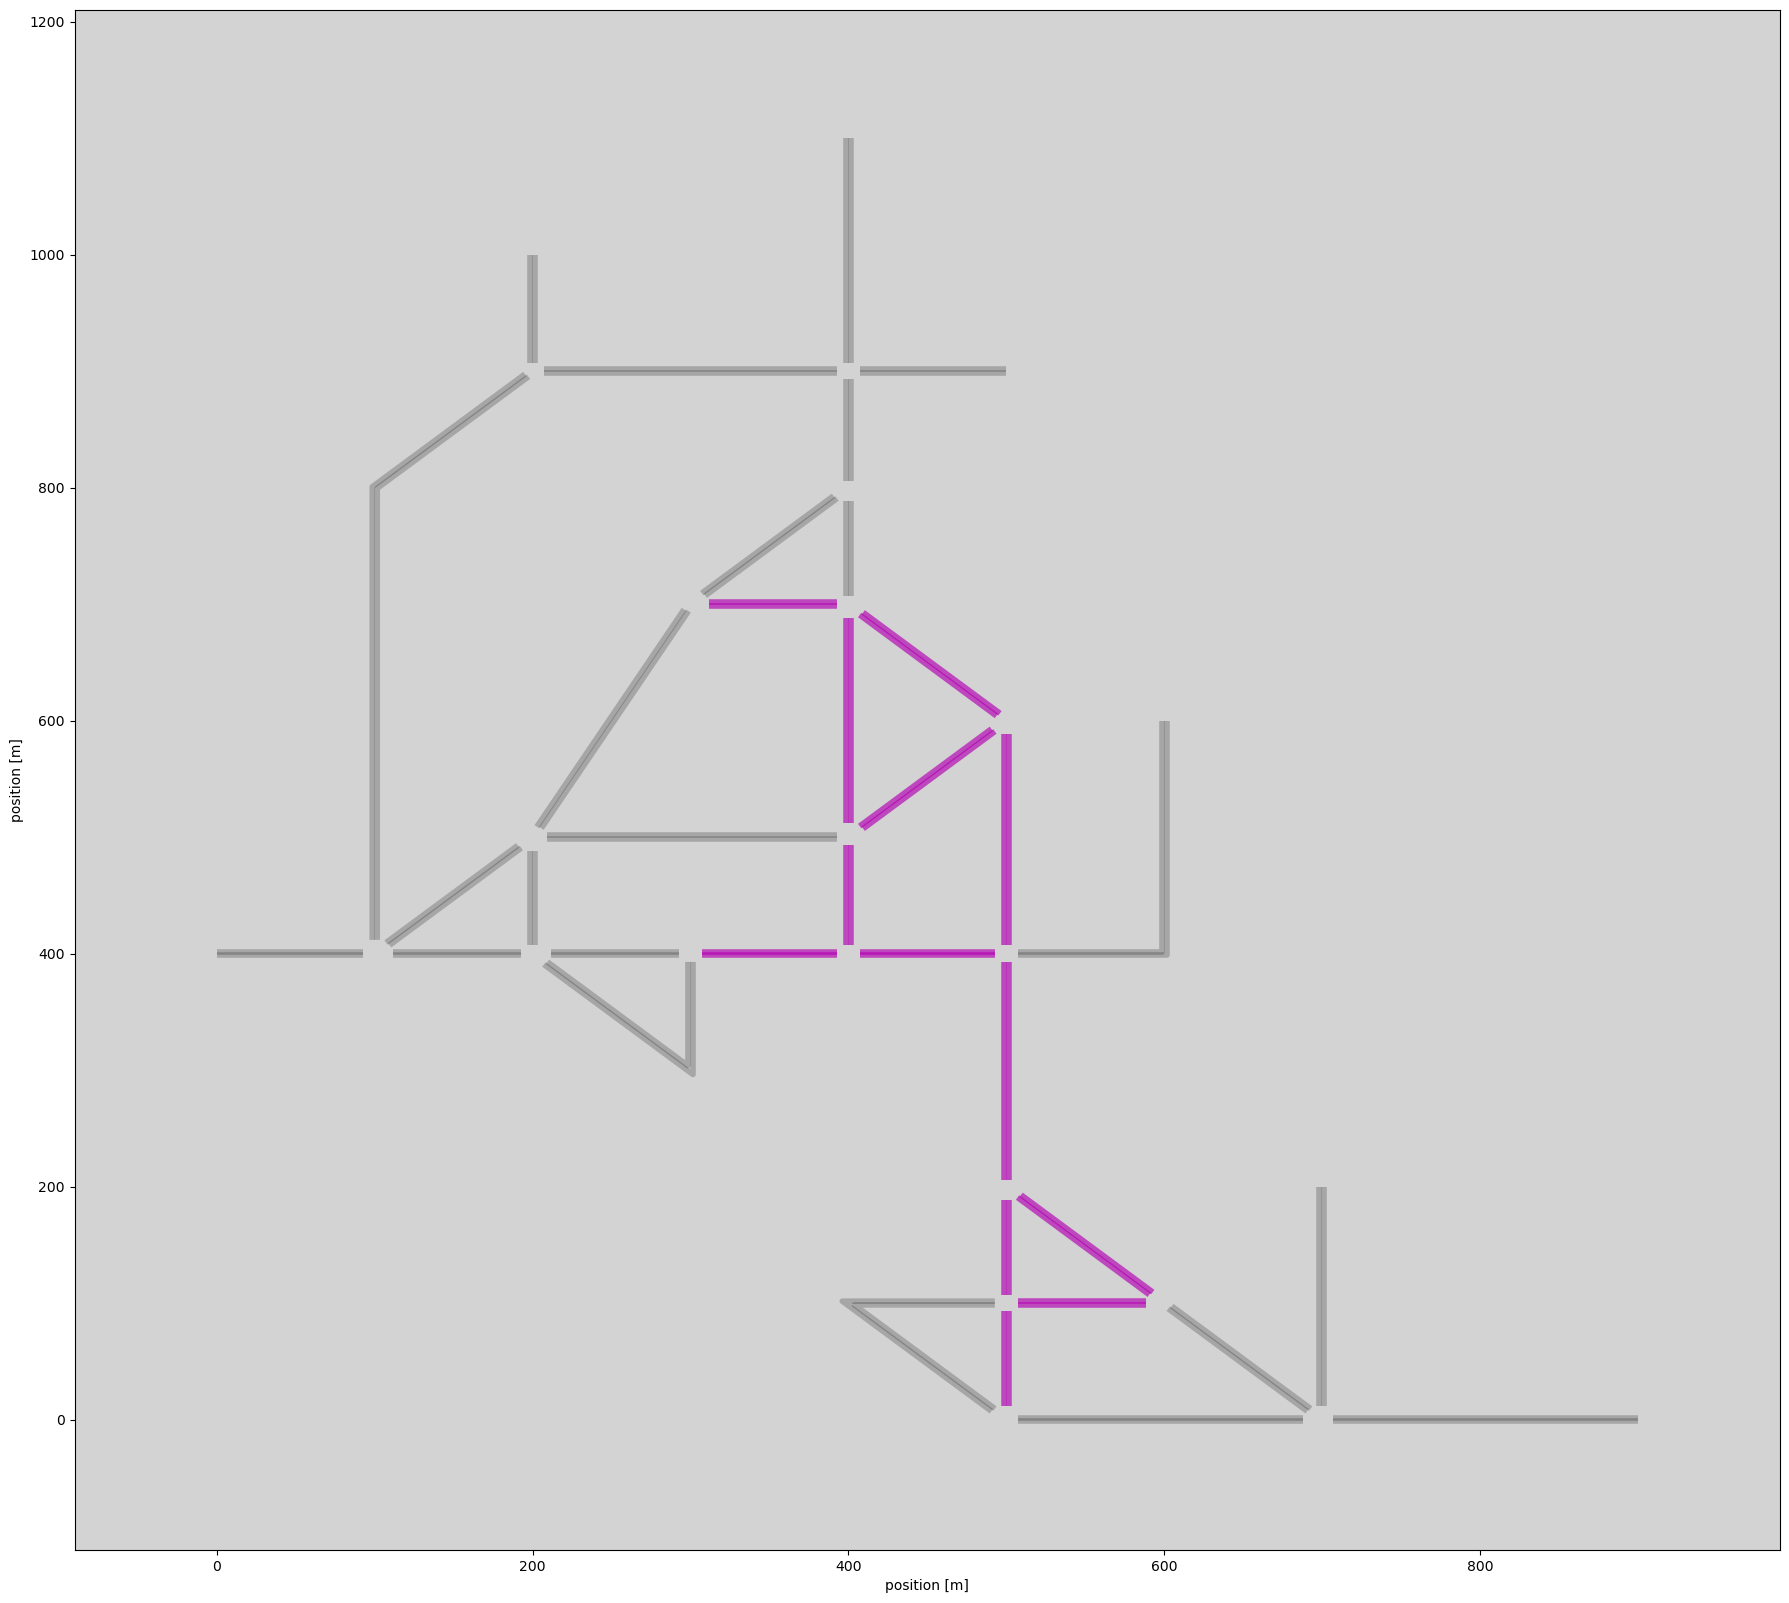

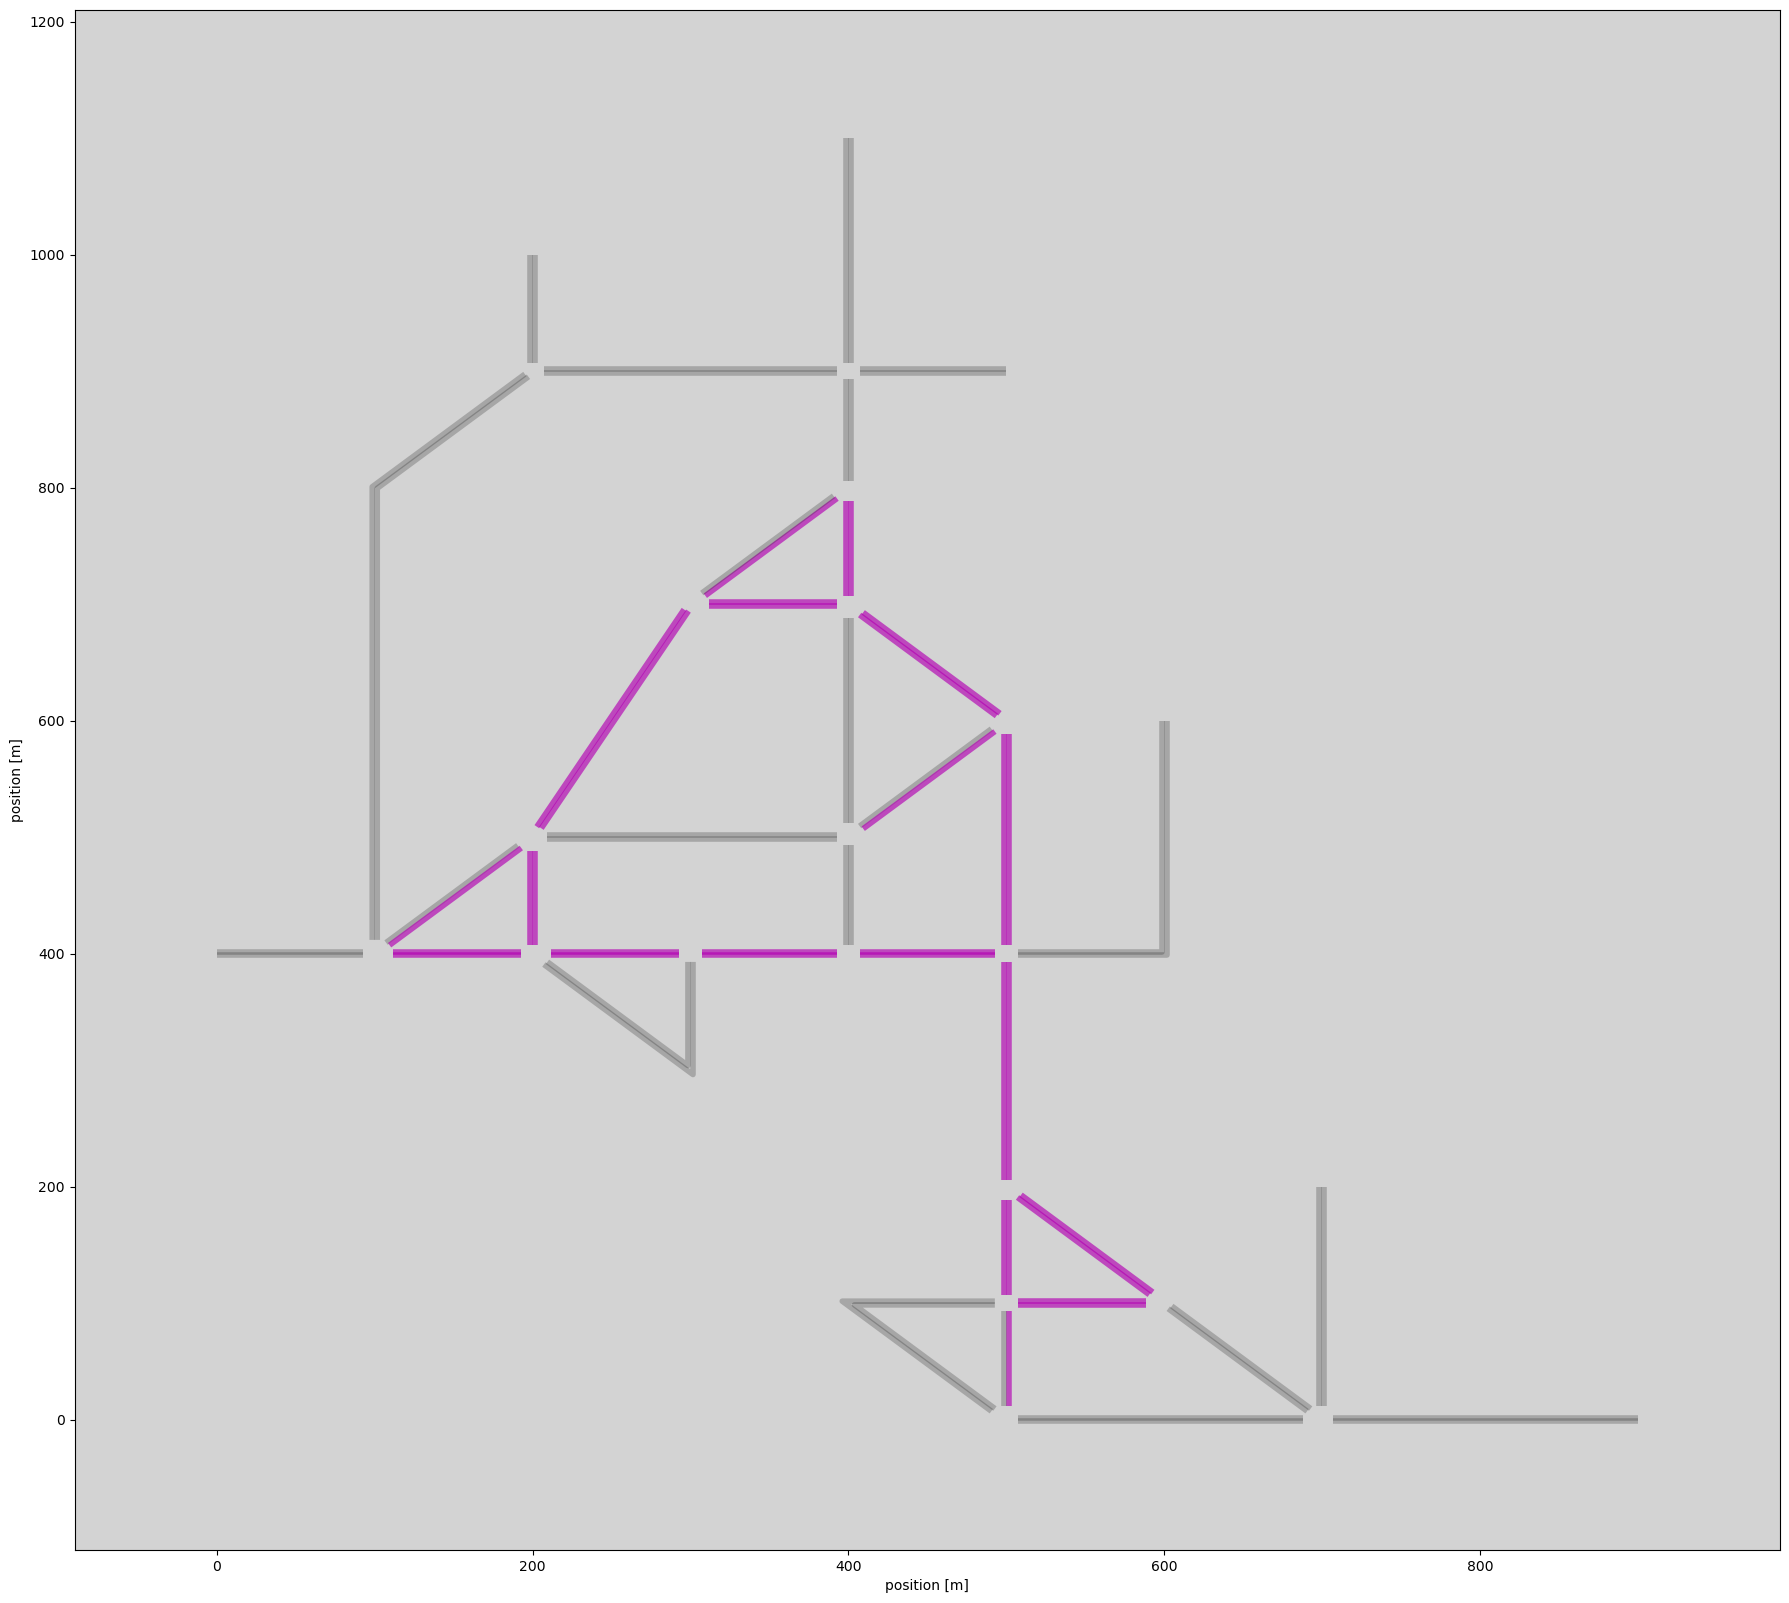

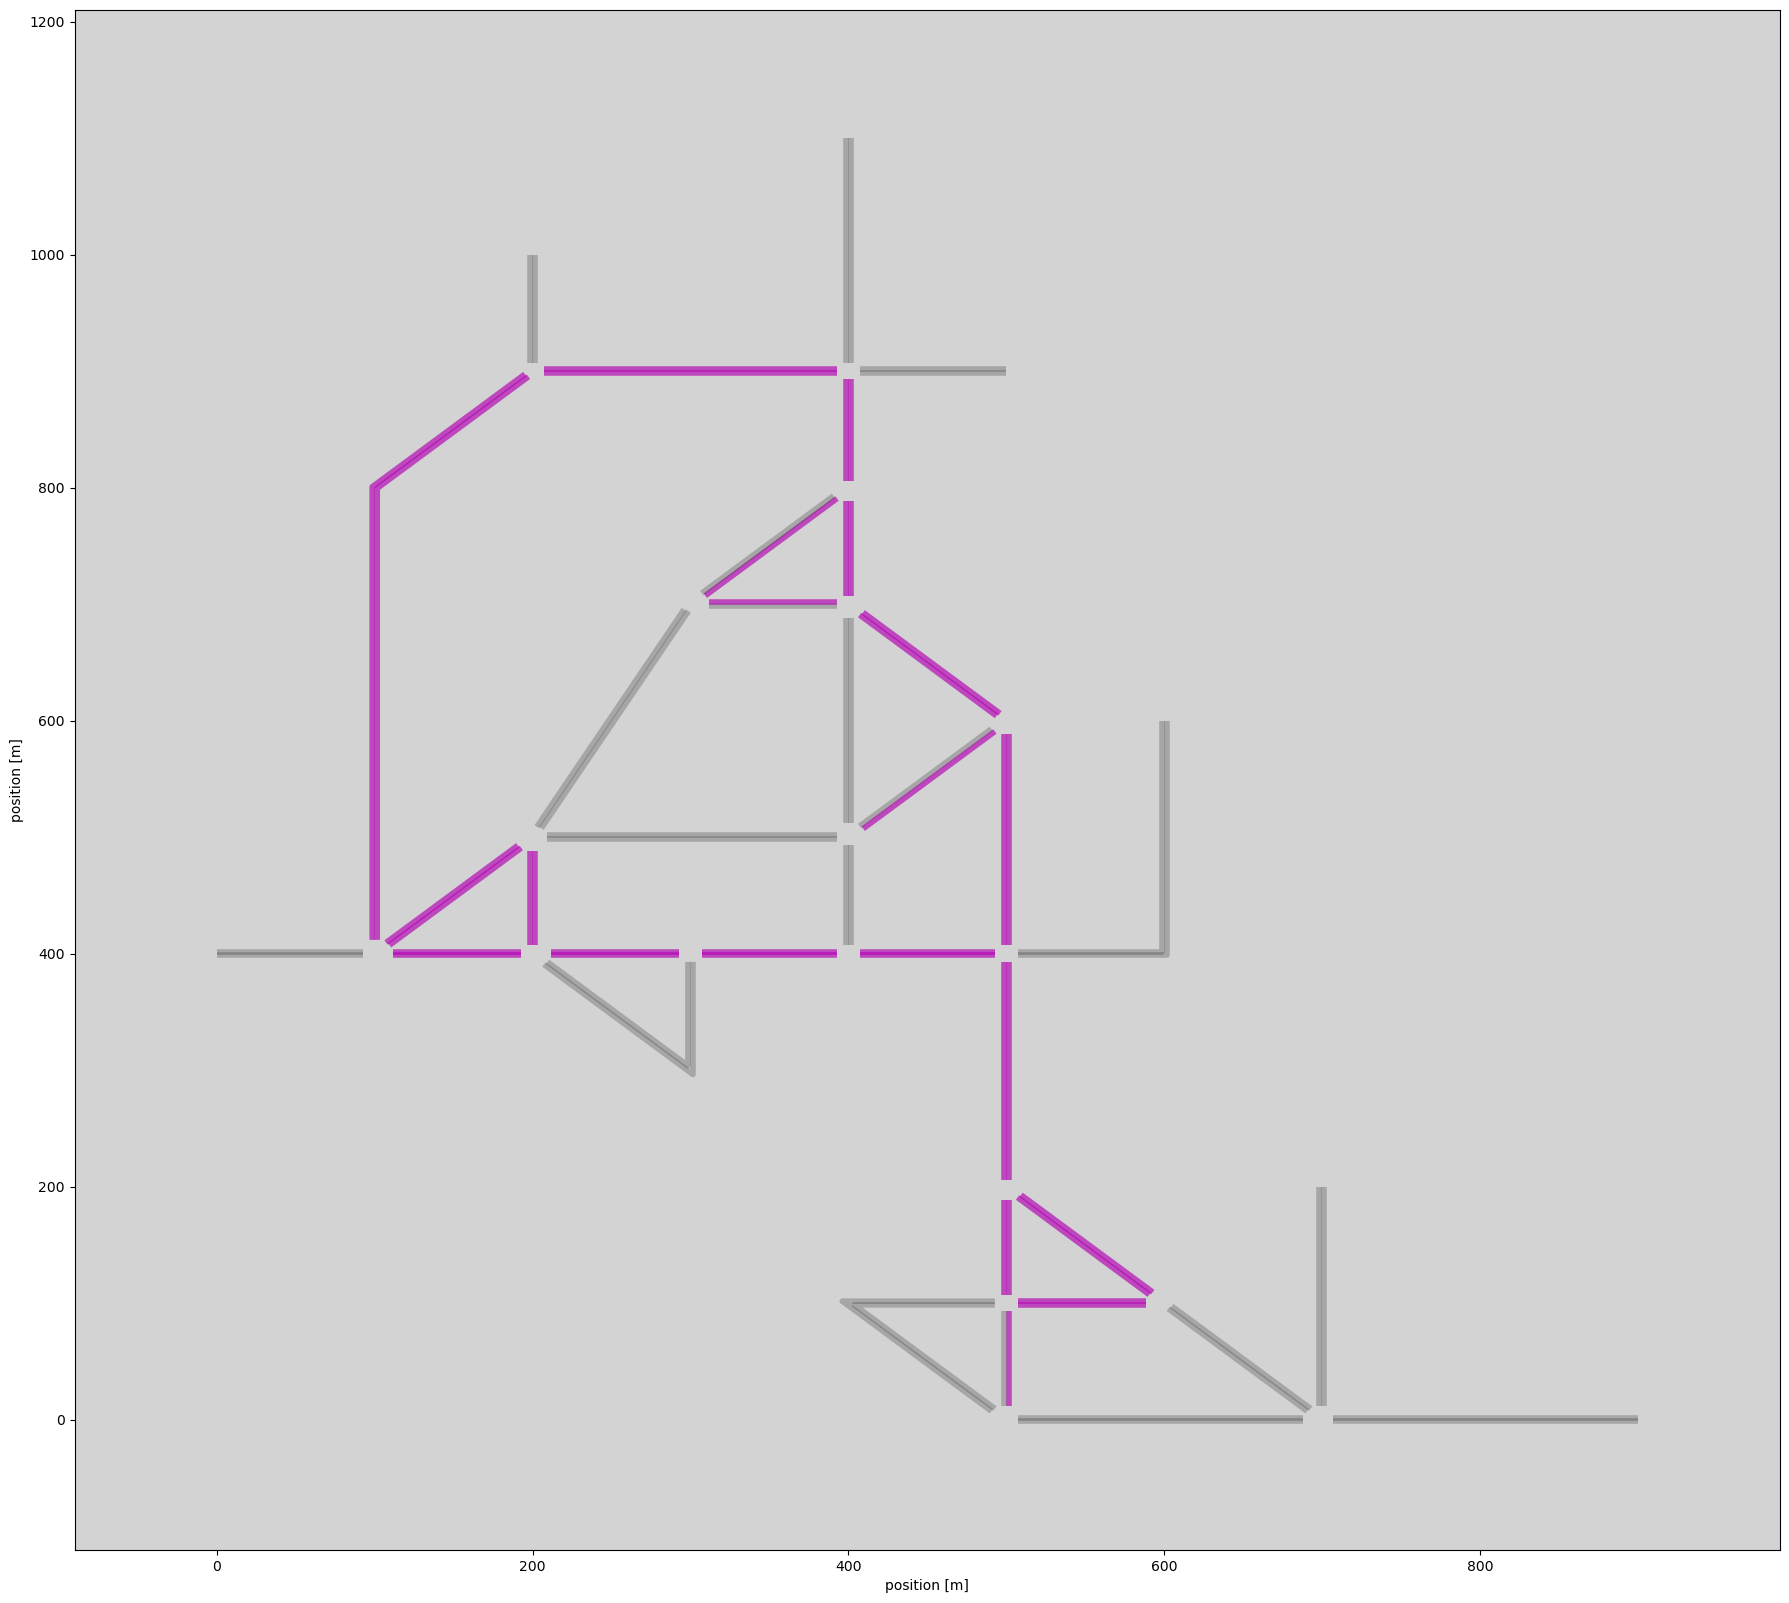

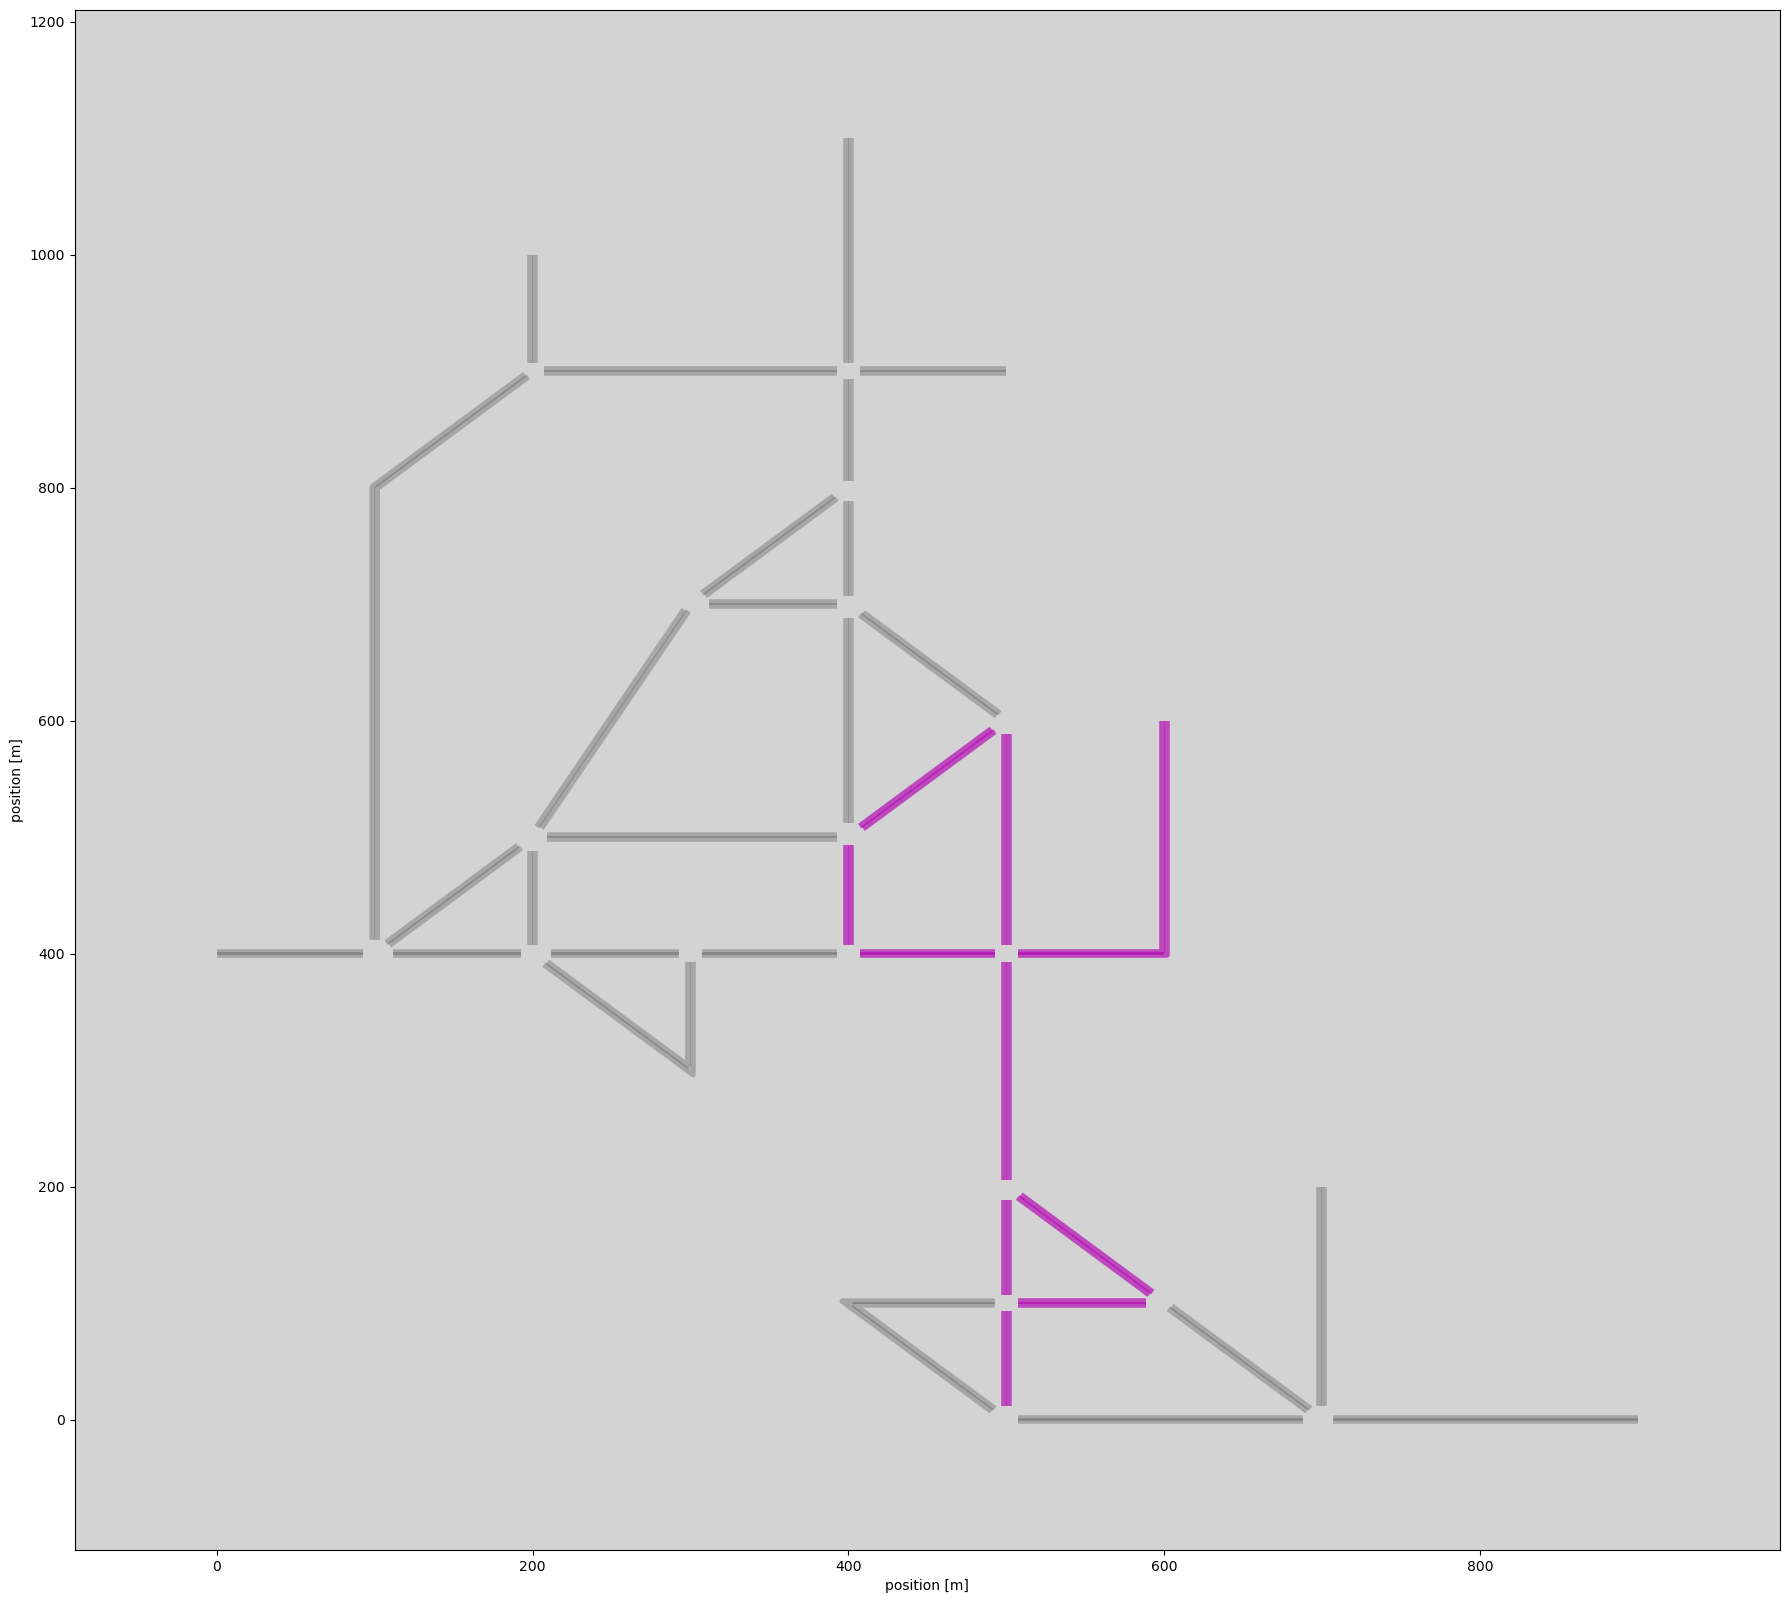

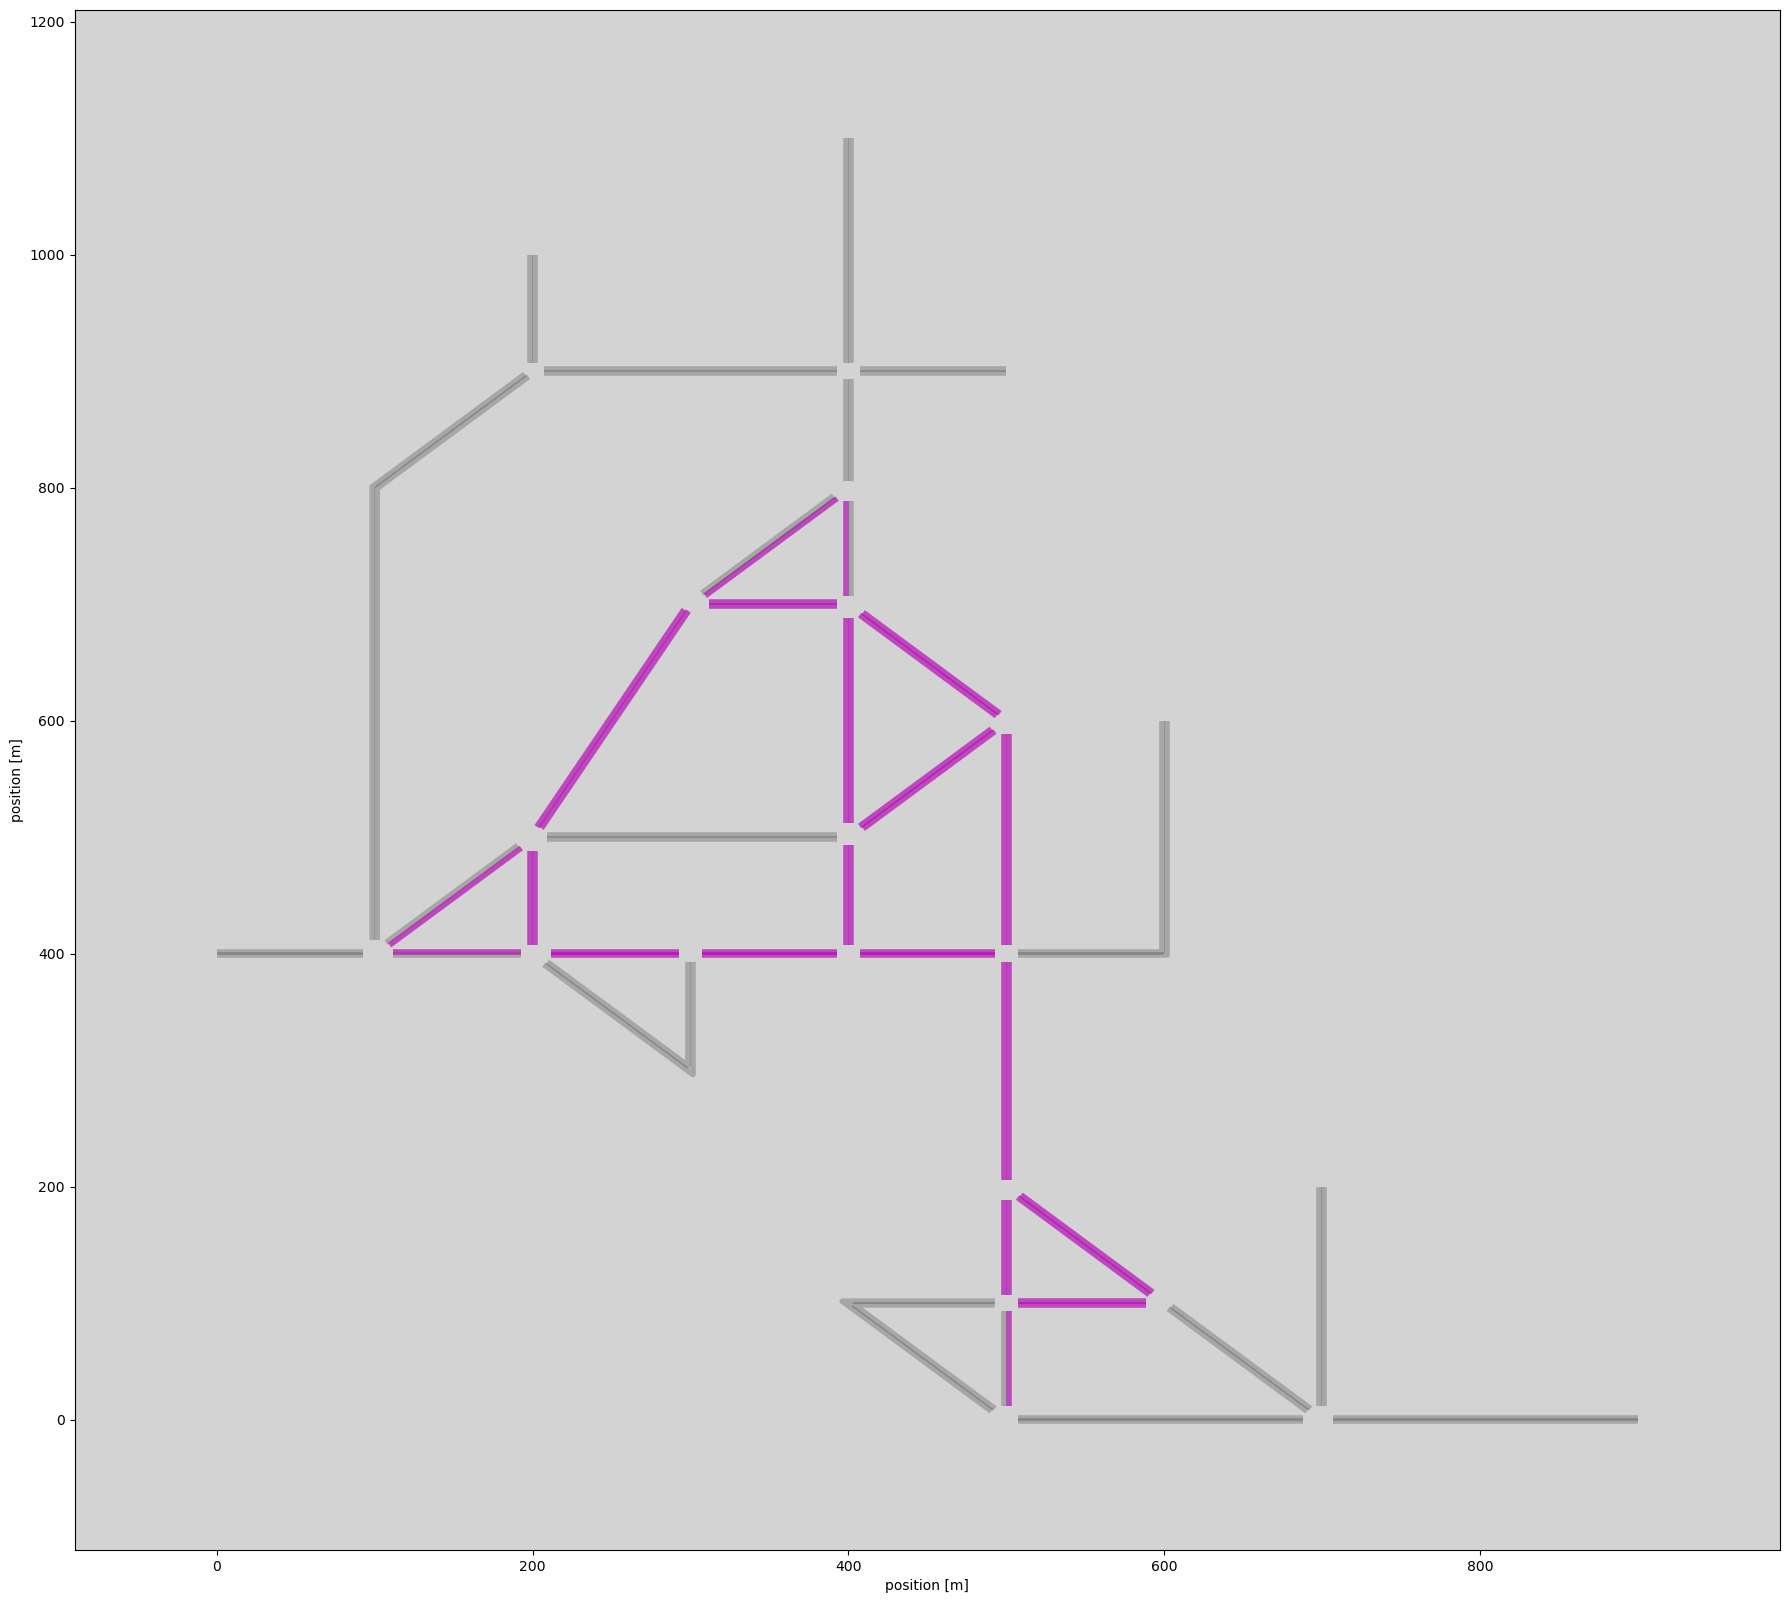

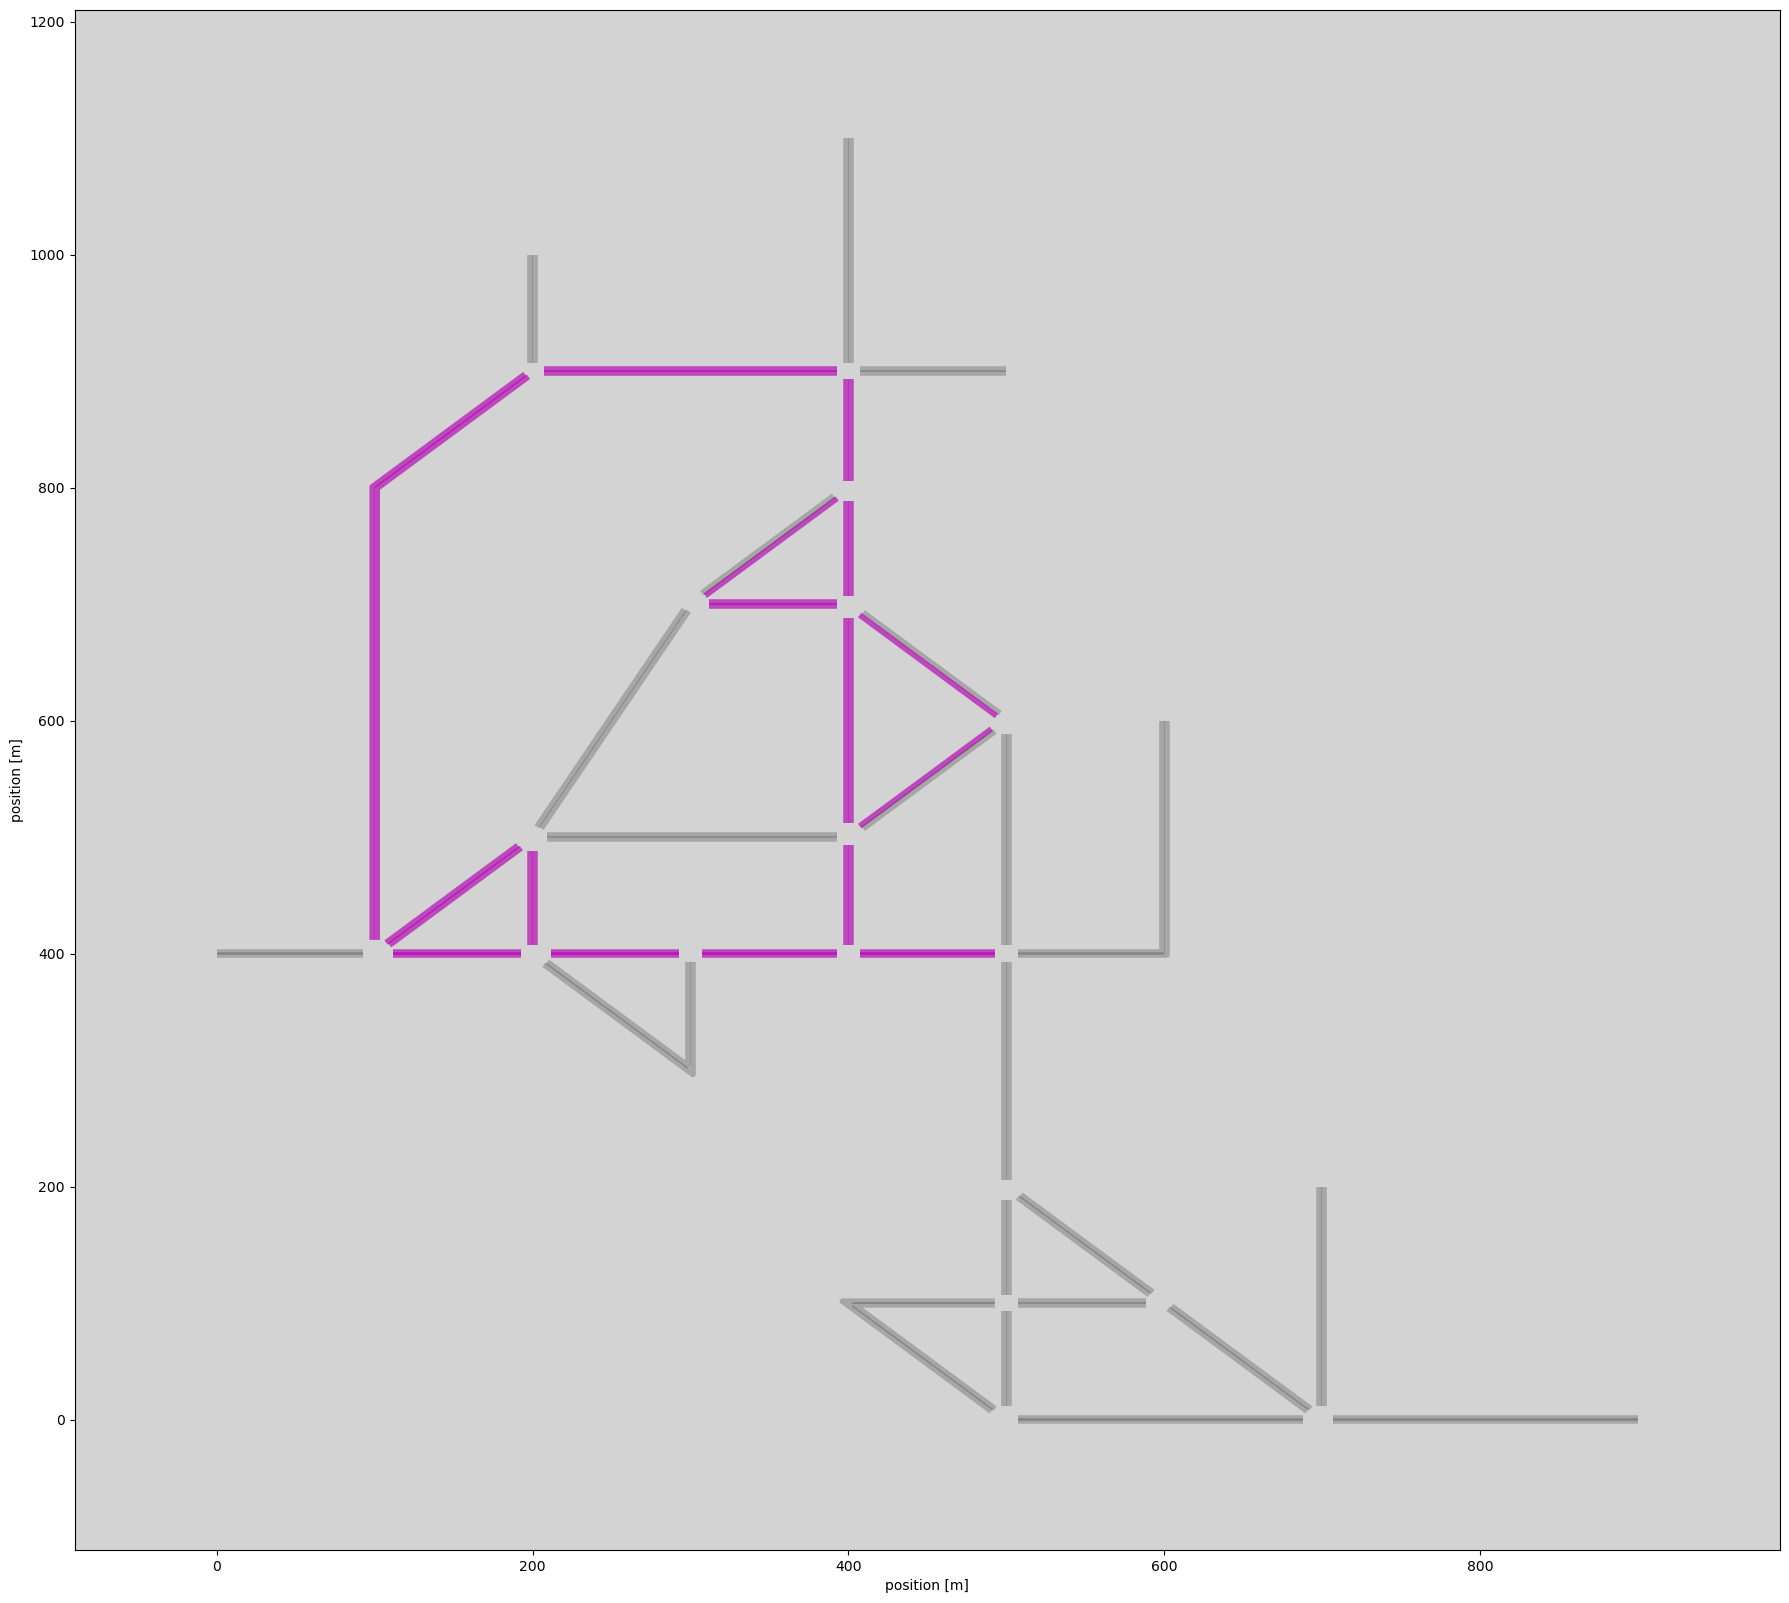

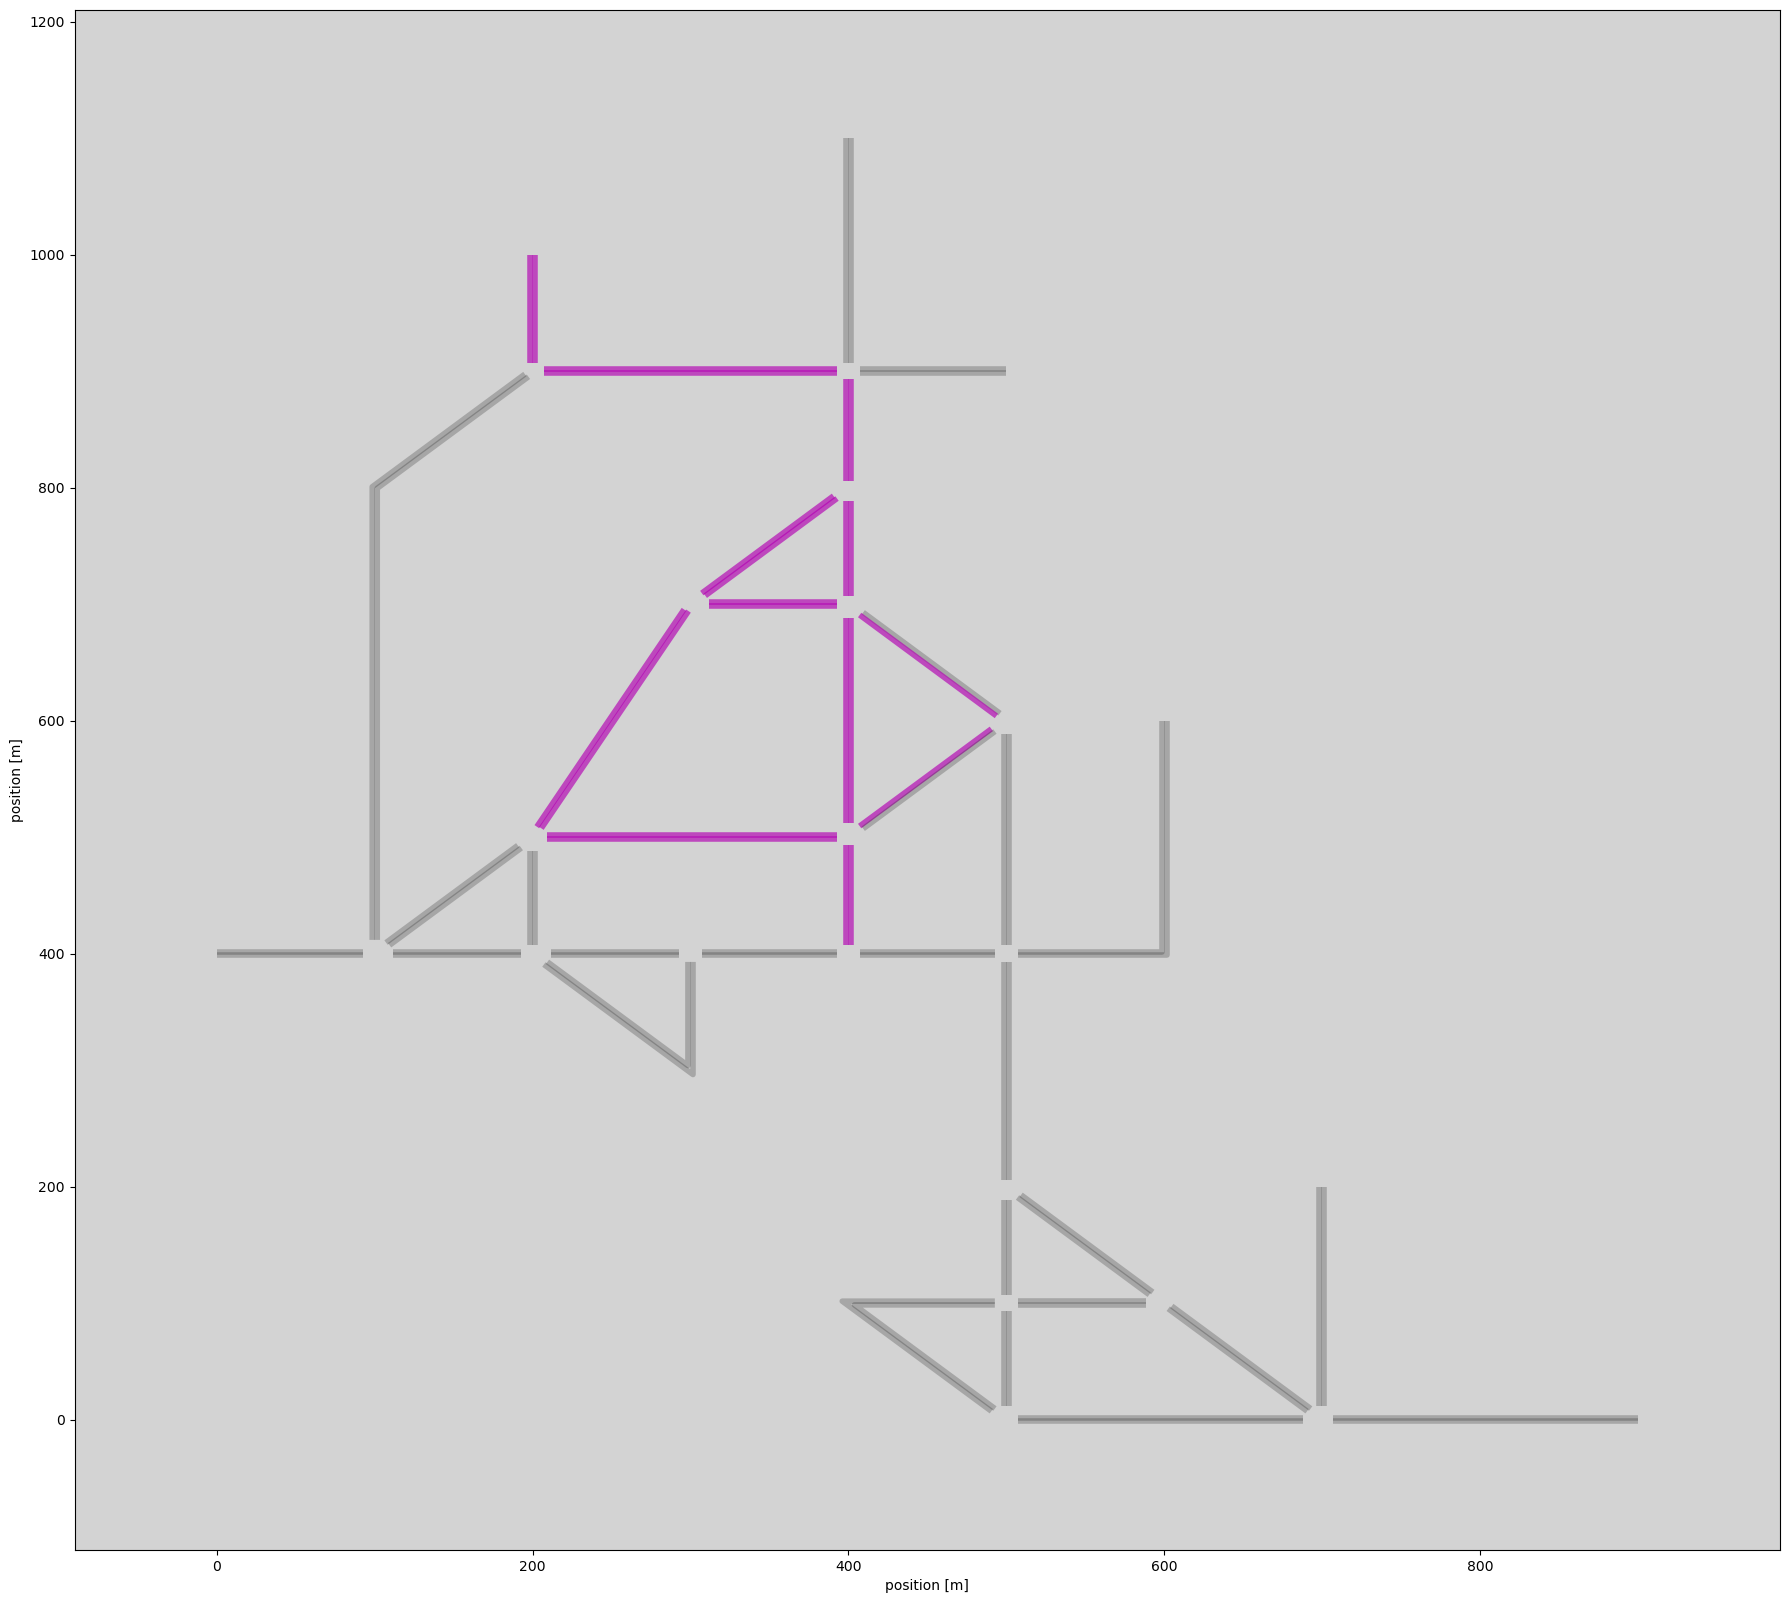

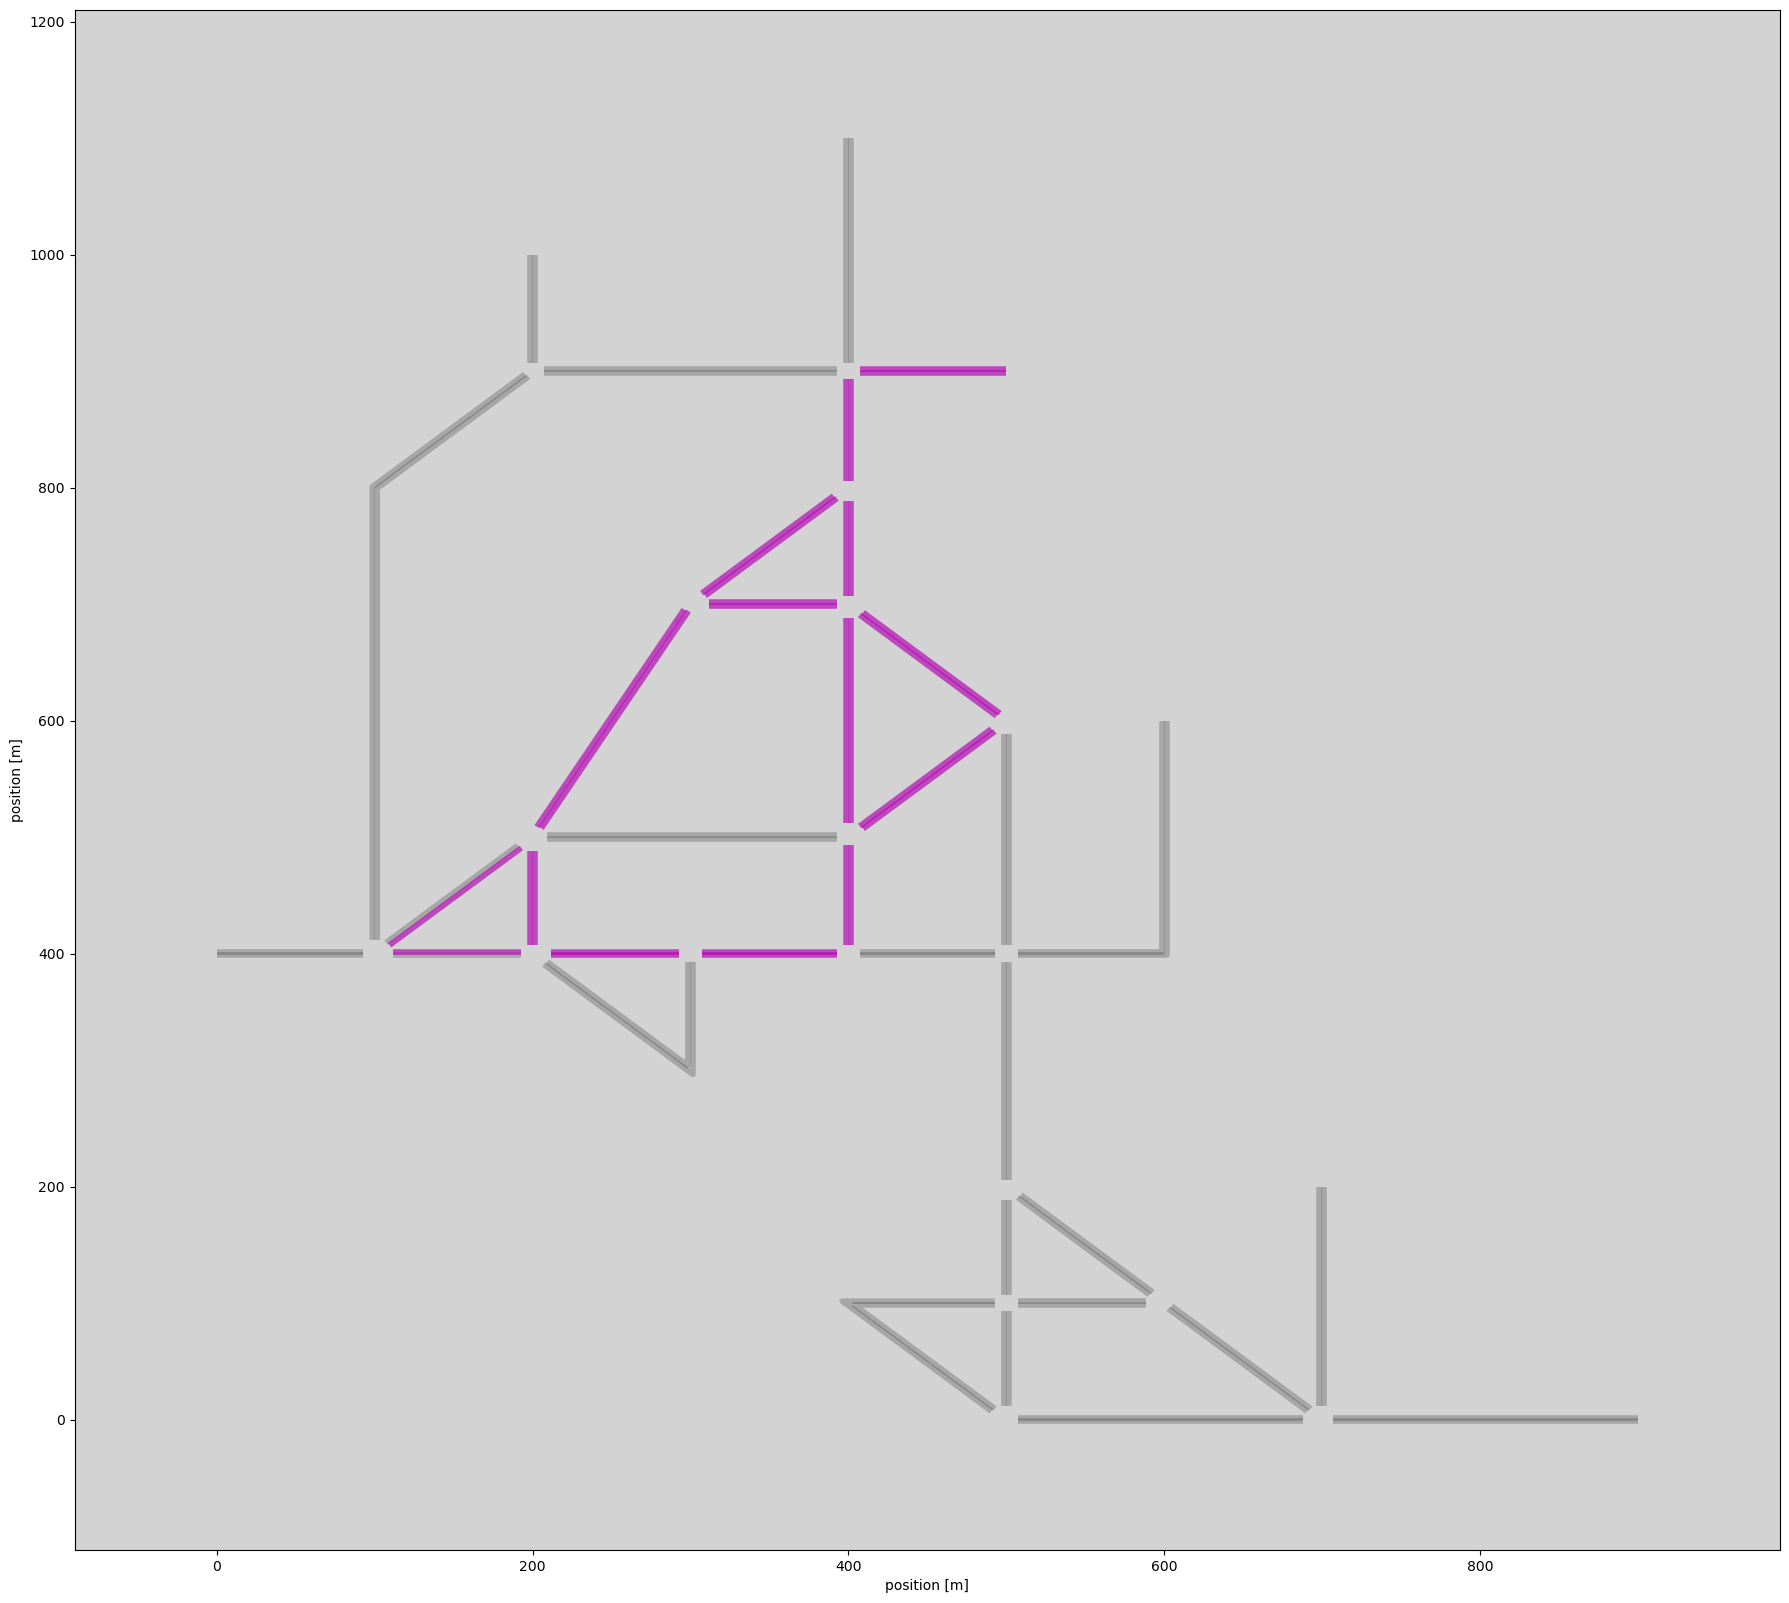

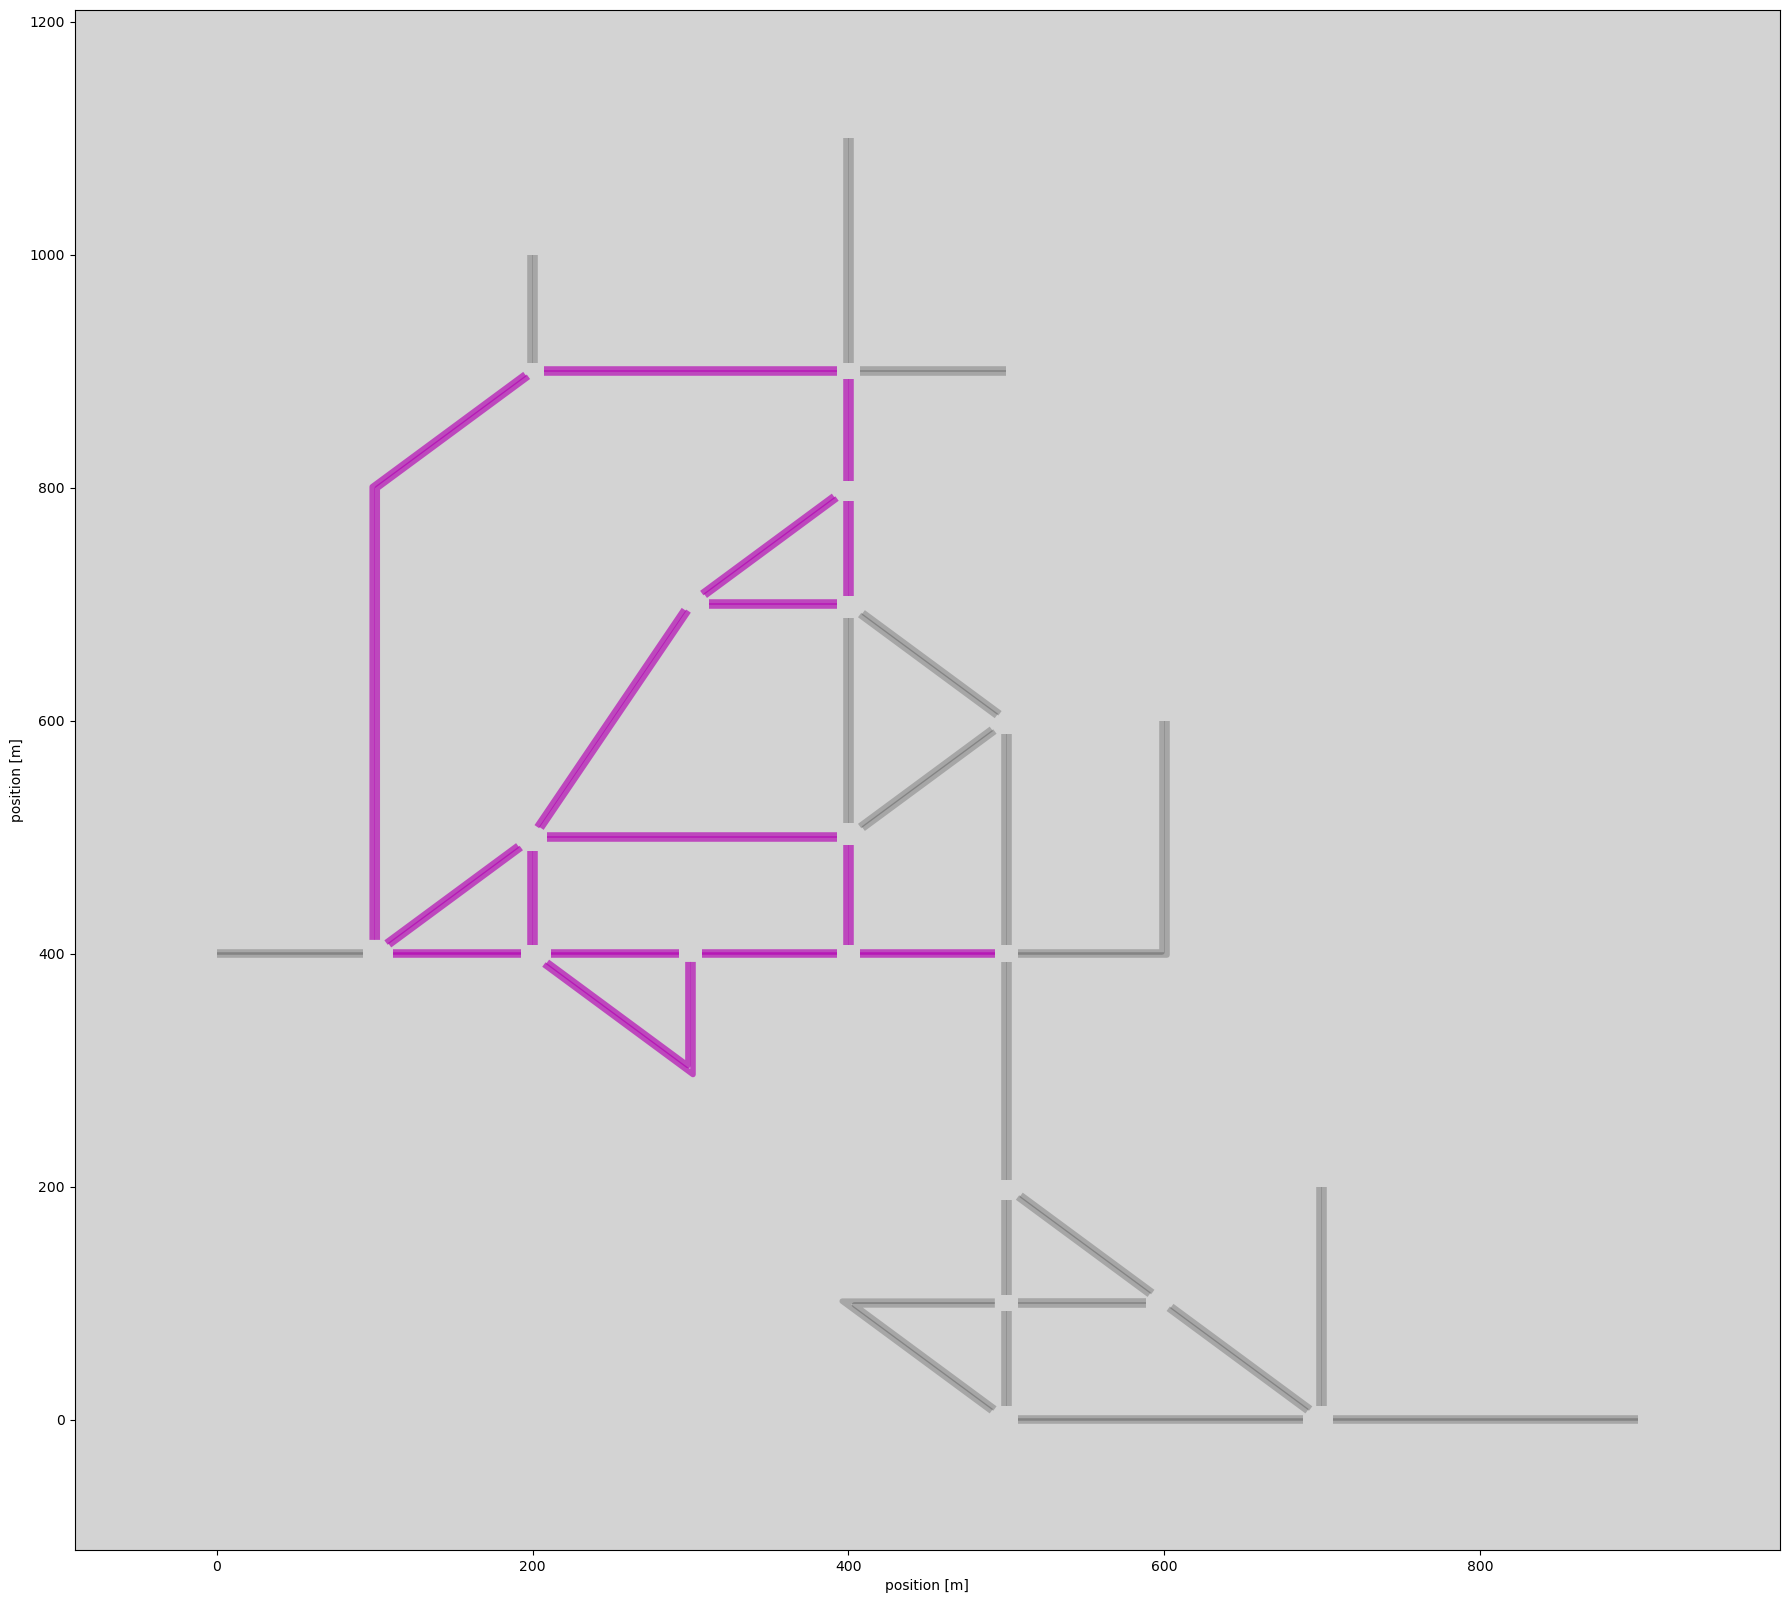

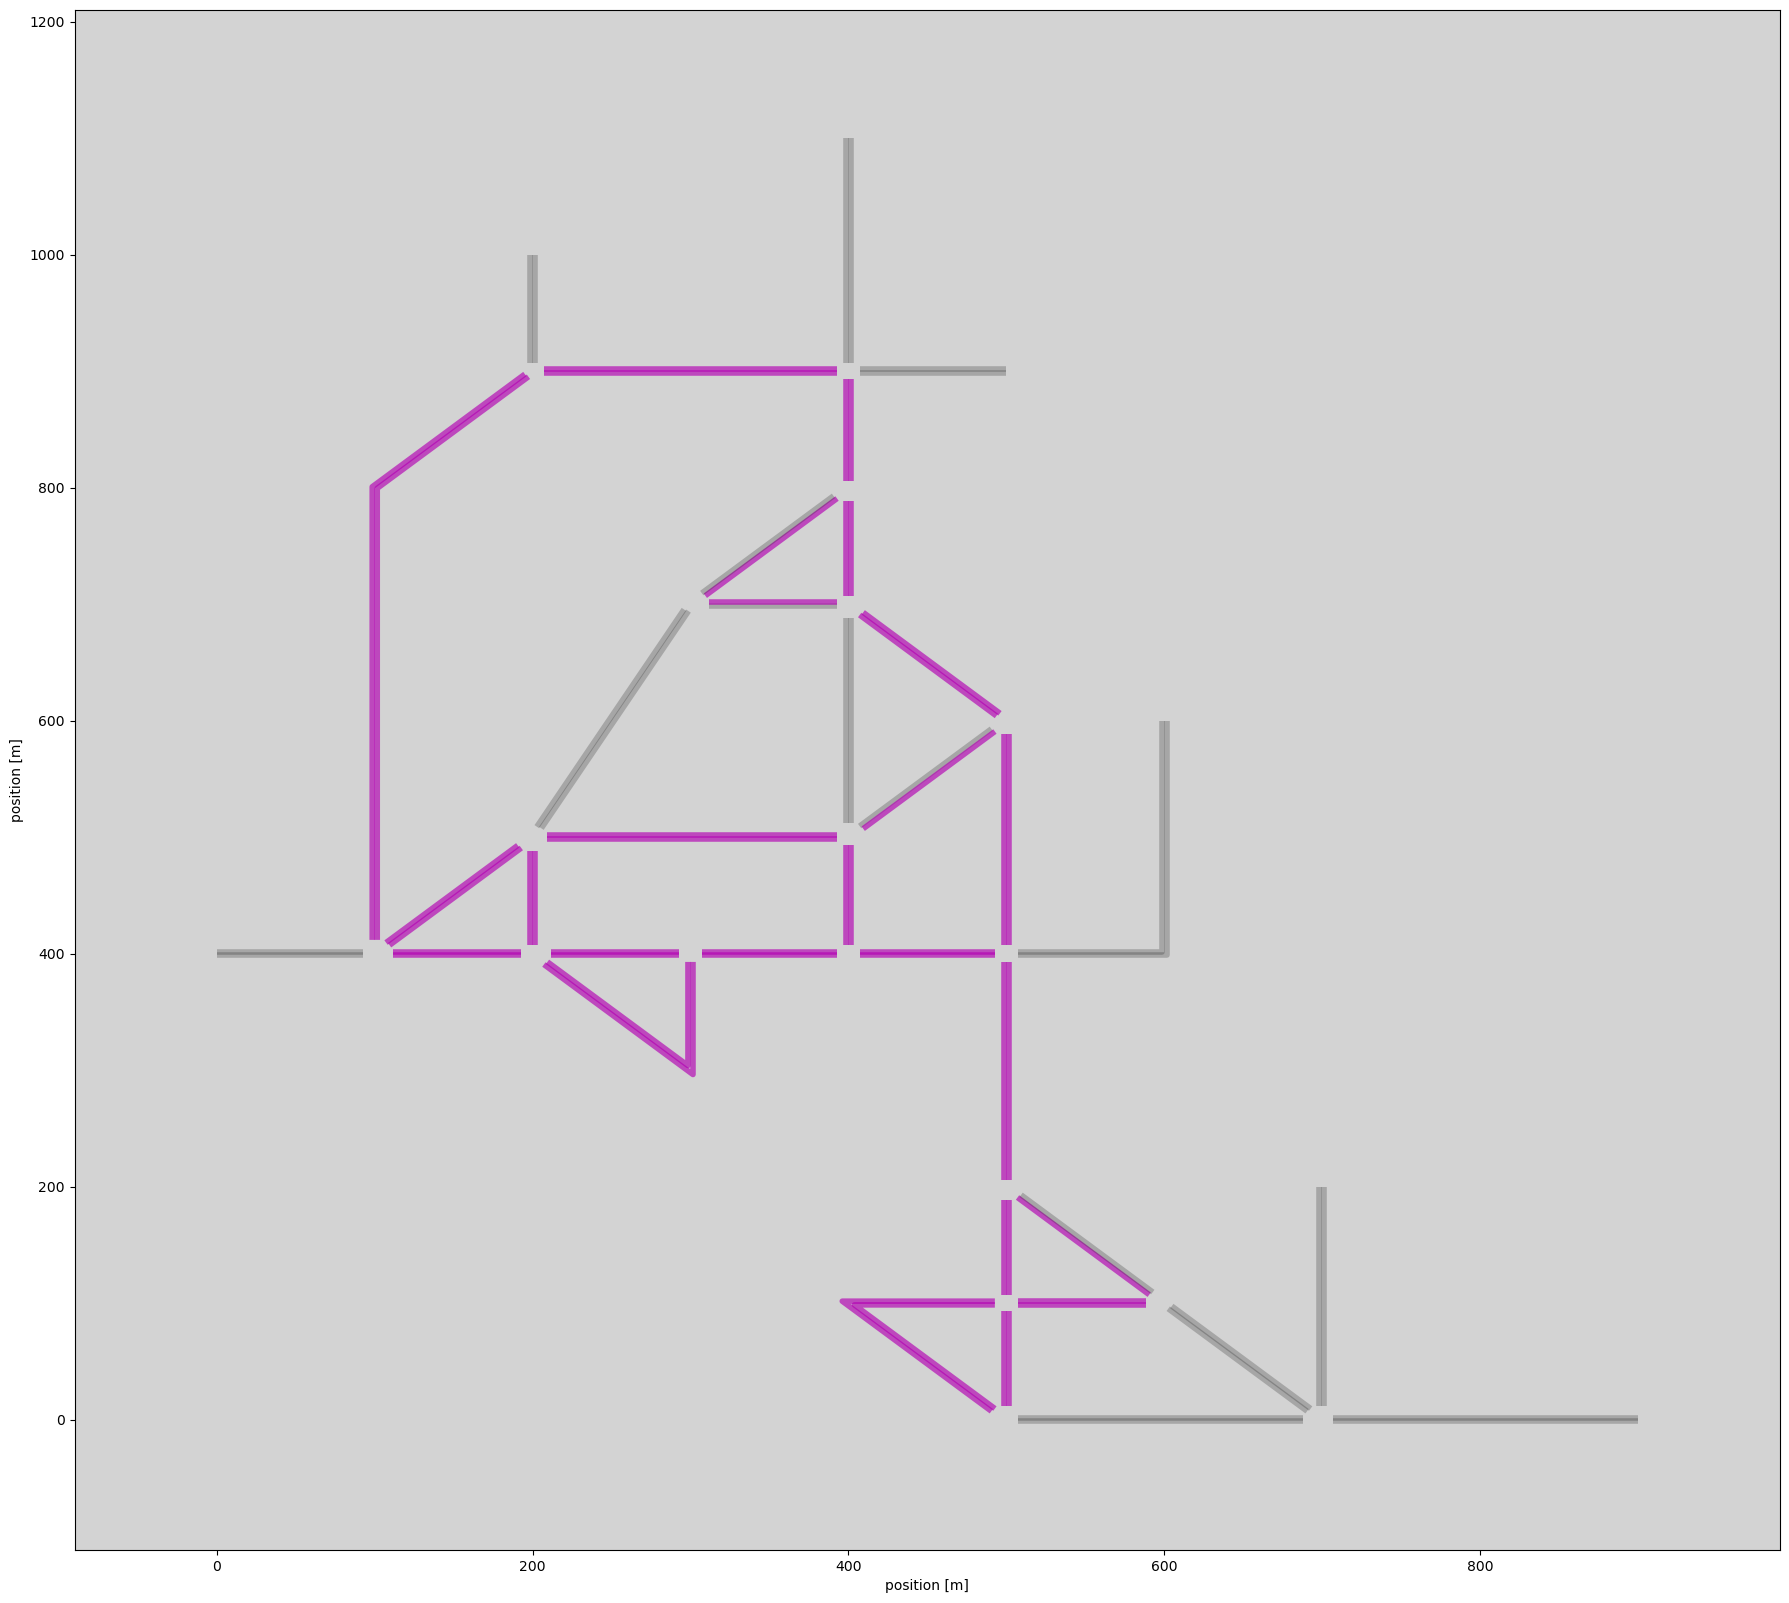

In [30]:
cluster0 = household_gl_df[household_gl_df["cluster"] == 0].index[:10]
for veh in cluster0:
    p_veh_data = p_data[p_data["veh_id"] == veh]
    print(len(p_veh_data), "/", len(p_veh_data["parking_id"].unique()))
    veh_lots = p_veh_data["parking_id"]
    visualization.plot_dataset(NET_FILE, veh_lots, parking_positions)

### 2.3 Moving times

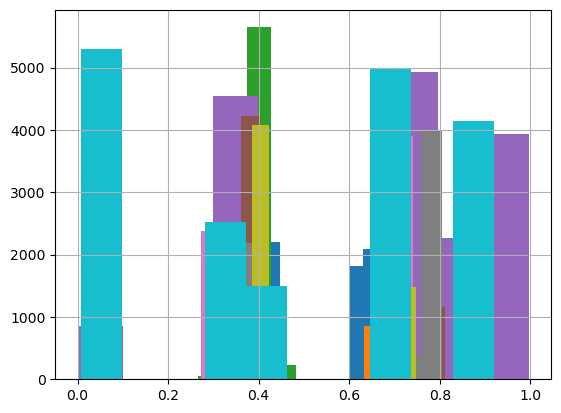

In [31]:
cluster0 = household_gl_df[household_gl_df["cluster"] == 0].index[:10]
for veh in cluster0:
    p_veh_data = p_data[p_data["veh_id"] == veh]
    p_veh_data["time_of_day"].hist()
    #plt.show()

In [32]:
def collect_cluster_data(p_data, cluster_indices):
    cl_data = []
    for ind in cluster_indices:
        p_veh_data = p_data[p_data["veh_id"] == ind]
        for i,r in p_veh_data.iterrows():
            cl_data.append(r.time_of_day)
    return cl_data

In [33]:
cl0_data = collect_cluster_data(p_data, cluster0)
cl0_data = np.array(cl0_data)*24

Text(0.5, 0, 'time [h]')

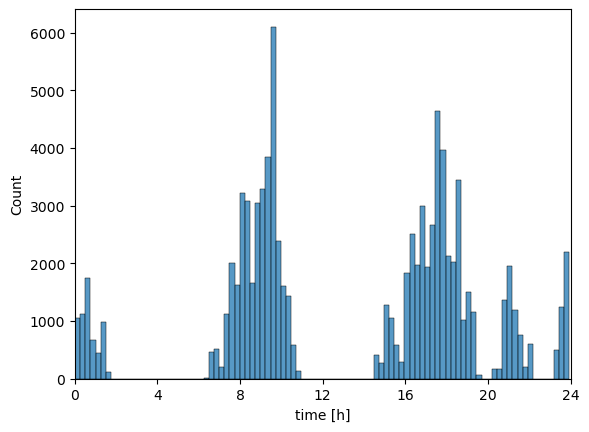

In [34]:
import seaborn as sns
sns.histplot(cl0_data, bins=24*4,)# kde=True)
plt.xlim(0, 24)
plt.xticks(ticks=[0, 4, 8, 12, 16, 20, 24])
plt.xlabel("time [h]")

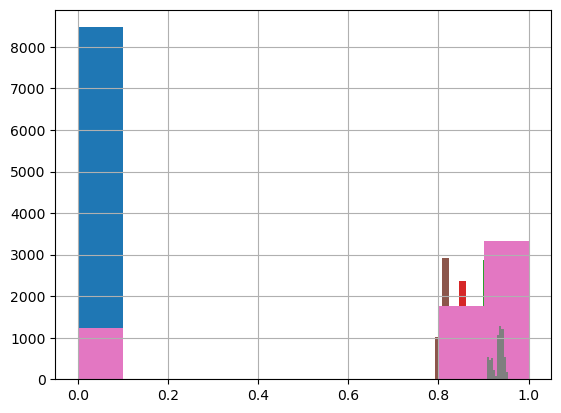

In [35]:
cluster1 = household_gl_df[household_gl_df["cluster"] == 1].index
for veh in cluster1:
    p_veh_data = p_data[p_data["veh_id"] == veh]
    p_veh_data["time_of_day"].hist()
    #plt.show()

In [36]:
cl1_data = collect_cluster_data(p_data, cluster1)
cl1_data = np.array(cl1_data)*24

Text(0.5, 0, 'time [h]')

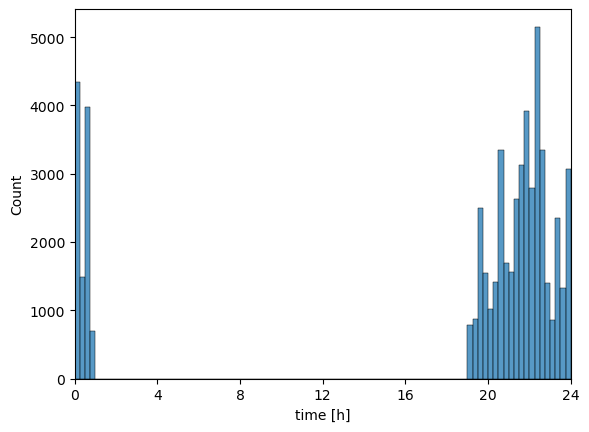

In [37]:
sns.histplot(cl1_data, bins=24*4,)
plt.xlim(0, 24)
plt.xticks(ticks=[0, 4, 8, 12, 16, 20, 24])
plt.xlabel("time [h]")